In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks
from scipy.stats import binned_statistic
import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm



/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta']


##  Data reading

In [74]:
run         = 'Run22'
run_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{run}"

nchannels       = 10
nevents_per_wvf = 500

samples_per_waveform = 752

event_header_bytes = 28
# event_header_bytes = 3036

# sample_binning = 1
sample_binning = 8e-9

nfiles = 10

# fixBaselines_noAmp = {'CH1': -369.89
#                       ,'CH2': -410.61
#                       ,'CH3': -350.80
#                       ,'CH4': -408.68
#                       }
# fixBaselines_Amp = {'CH1': -485.60
#                     ,'CH2': -486.59
#                     ,'CH3': -485.52
#                     ,'CH4': -485.15
#                     }
fixBaselines_noAmp = {'CH1': -369
                      ,'CH2': -410
                      ,'CH3': -350
                      ,'CH4': -408
                      }
amp_offset = 600
fixBaselines_Amp = {'CH1': -amp_offset
                    ,'CH2': -amp_offset
                    ,'CH3': -amp_offset
                    ,'CH4': -amp_offset
                    }

In [4]:
# CHECK WAVEFORMS' SIZES
print_headers = False
# --- Example usage ---
if __name__ == "__main__":

    for file in os.listdir(run_dir)[:5]:
        if file.endswith(".bin"):
            file_path = os.path.join(run_dir, file)
        path = file_path

        waveforms, headers = parse_data.load_waveforms_until_eof(
            path,
            channels=nchannels,
            samples_per_waveform=samples_per_waveform,
            dtype="<f4",
            event_header_bytes=event_header_bytes,  # set to 0 if no per-event header
        )

        print("Waveforms shape:", waveforms.shape)  # (num_events, 4, 500)
        if print_headers:
            if headers is not None:
                print("Headers shape:", headers.shape)   # (num_events, 7) for 28 bytes
                print("First header:", headers[0])


Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)
Waveforms shape: (500, 10, 752)


In [5]:

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_dir)[:nfiles],desc="Reading .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_dir, file)
        # print(file_path)
        df = parse_data.parse_wf_from_binary(file_path, 
                                             channels = nchannels, 
                                             n_events = nevents_per_wvf,
                                             file_idx = i,
                                             event_header_bytes = event_header_bytes,
                                             sample_binning = sample_binning
                                             )  
        dataframes.append(df)

Reading .bin files:   0%|          | 0/10 [00:00<?, ?file/s]

Reading .bin files: 100%|██████████| 10/10 [00:23<00:00,  2.38s/file]


In [6]:
# Merge all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)

In [7]:
df = merged_df
df.tail()

TIME       CH1       CH2         CH3         CH4         CH5  \
3759995  0.000006  3.000907  2.758770 -370.790405 -528.473206 -409.585693   
3759996  0.000006  3.062150  2.881382 -370.175995 -525.833923 -410.200134   
3759997  0.000006  2.817178  2.697464 -370.237427 -529.209717 -409.708588   
3759998  0.000006  2.510963  2.390934 -369.930237 -536.268311 -409.462830   
3759999  0.000006  2.388477  2.942688 -370.114563 -541.976562 -409.954376   

                CH6         CH7         CH8         CH9        CH10  event  \
3759995 -398.193298 -347.765808 -260.244415 -407.837830 -595.456848   4999   
3759996 -411.687225 -348.133942 -278.644897 -407.837830 -600.120361   4999   
3759997 -421.623657 -348.379364 -299.069458 -408.329926 -604.354309   4999   
3759998 -428.677307 -348.870209 -321.150055 -408.637512 -606.011108   4999   
3759999 -433.522858 -349.729187 -343.230652 -408.760529 -606.563354   4999   

           event_time  file_idx  
3759995  537826256870         9  
3759996  537826256870         9  
3759997  537826256870         9  
3759998  537826256870         9  
3759999  537826256870         9

##  Data selection

In [8]:
# Filter for a specific event (change index as needed)
event_list  = df['event'].unique()
nevents     = len(event_list)
print(f'Unfiltered df nevents = {nevents}')

Unfiltered df nevents = 5000


In [9]:
if nchannels == 5:
    Amp_channels    = ['CH2', 'CH3', 'CH4', 'CH5'] # Amp
    noAmp_channels  = [] # noAmp

elif nchannels == 9:
    Amp_channels    = ['CH3', 'CH5', 'CH7', 'CH9'] # Amp
    noAmp_channels  = ['CH2', 'CH4', 'CH6', 'CH8'] # noAmp

elif nchannels == 10:
    Amp_channels    = ['CH4', 'CH6', 'CH8', 'CH10'] # Amp
    noAmp_channels  = ['CH3', 'CH5', 'CH7', 'CH9'] # noAmp


all_channels    = noAmp_channels + Amp_channels


In [10]:
selected_event = 230
df_event = df[df['event'] == event_list[selected_event]]  # Change the index to choose different event


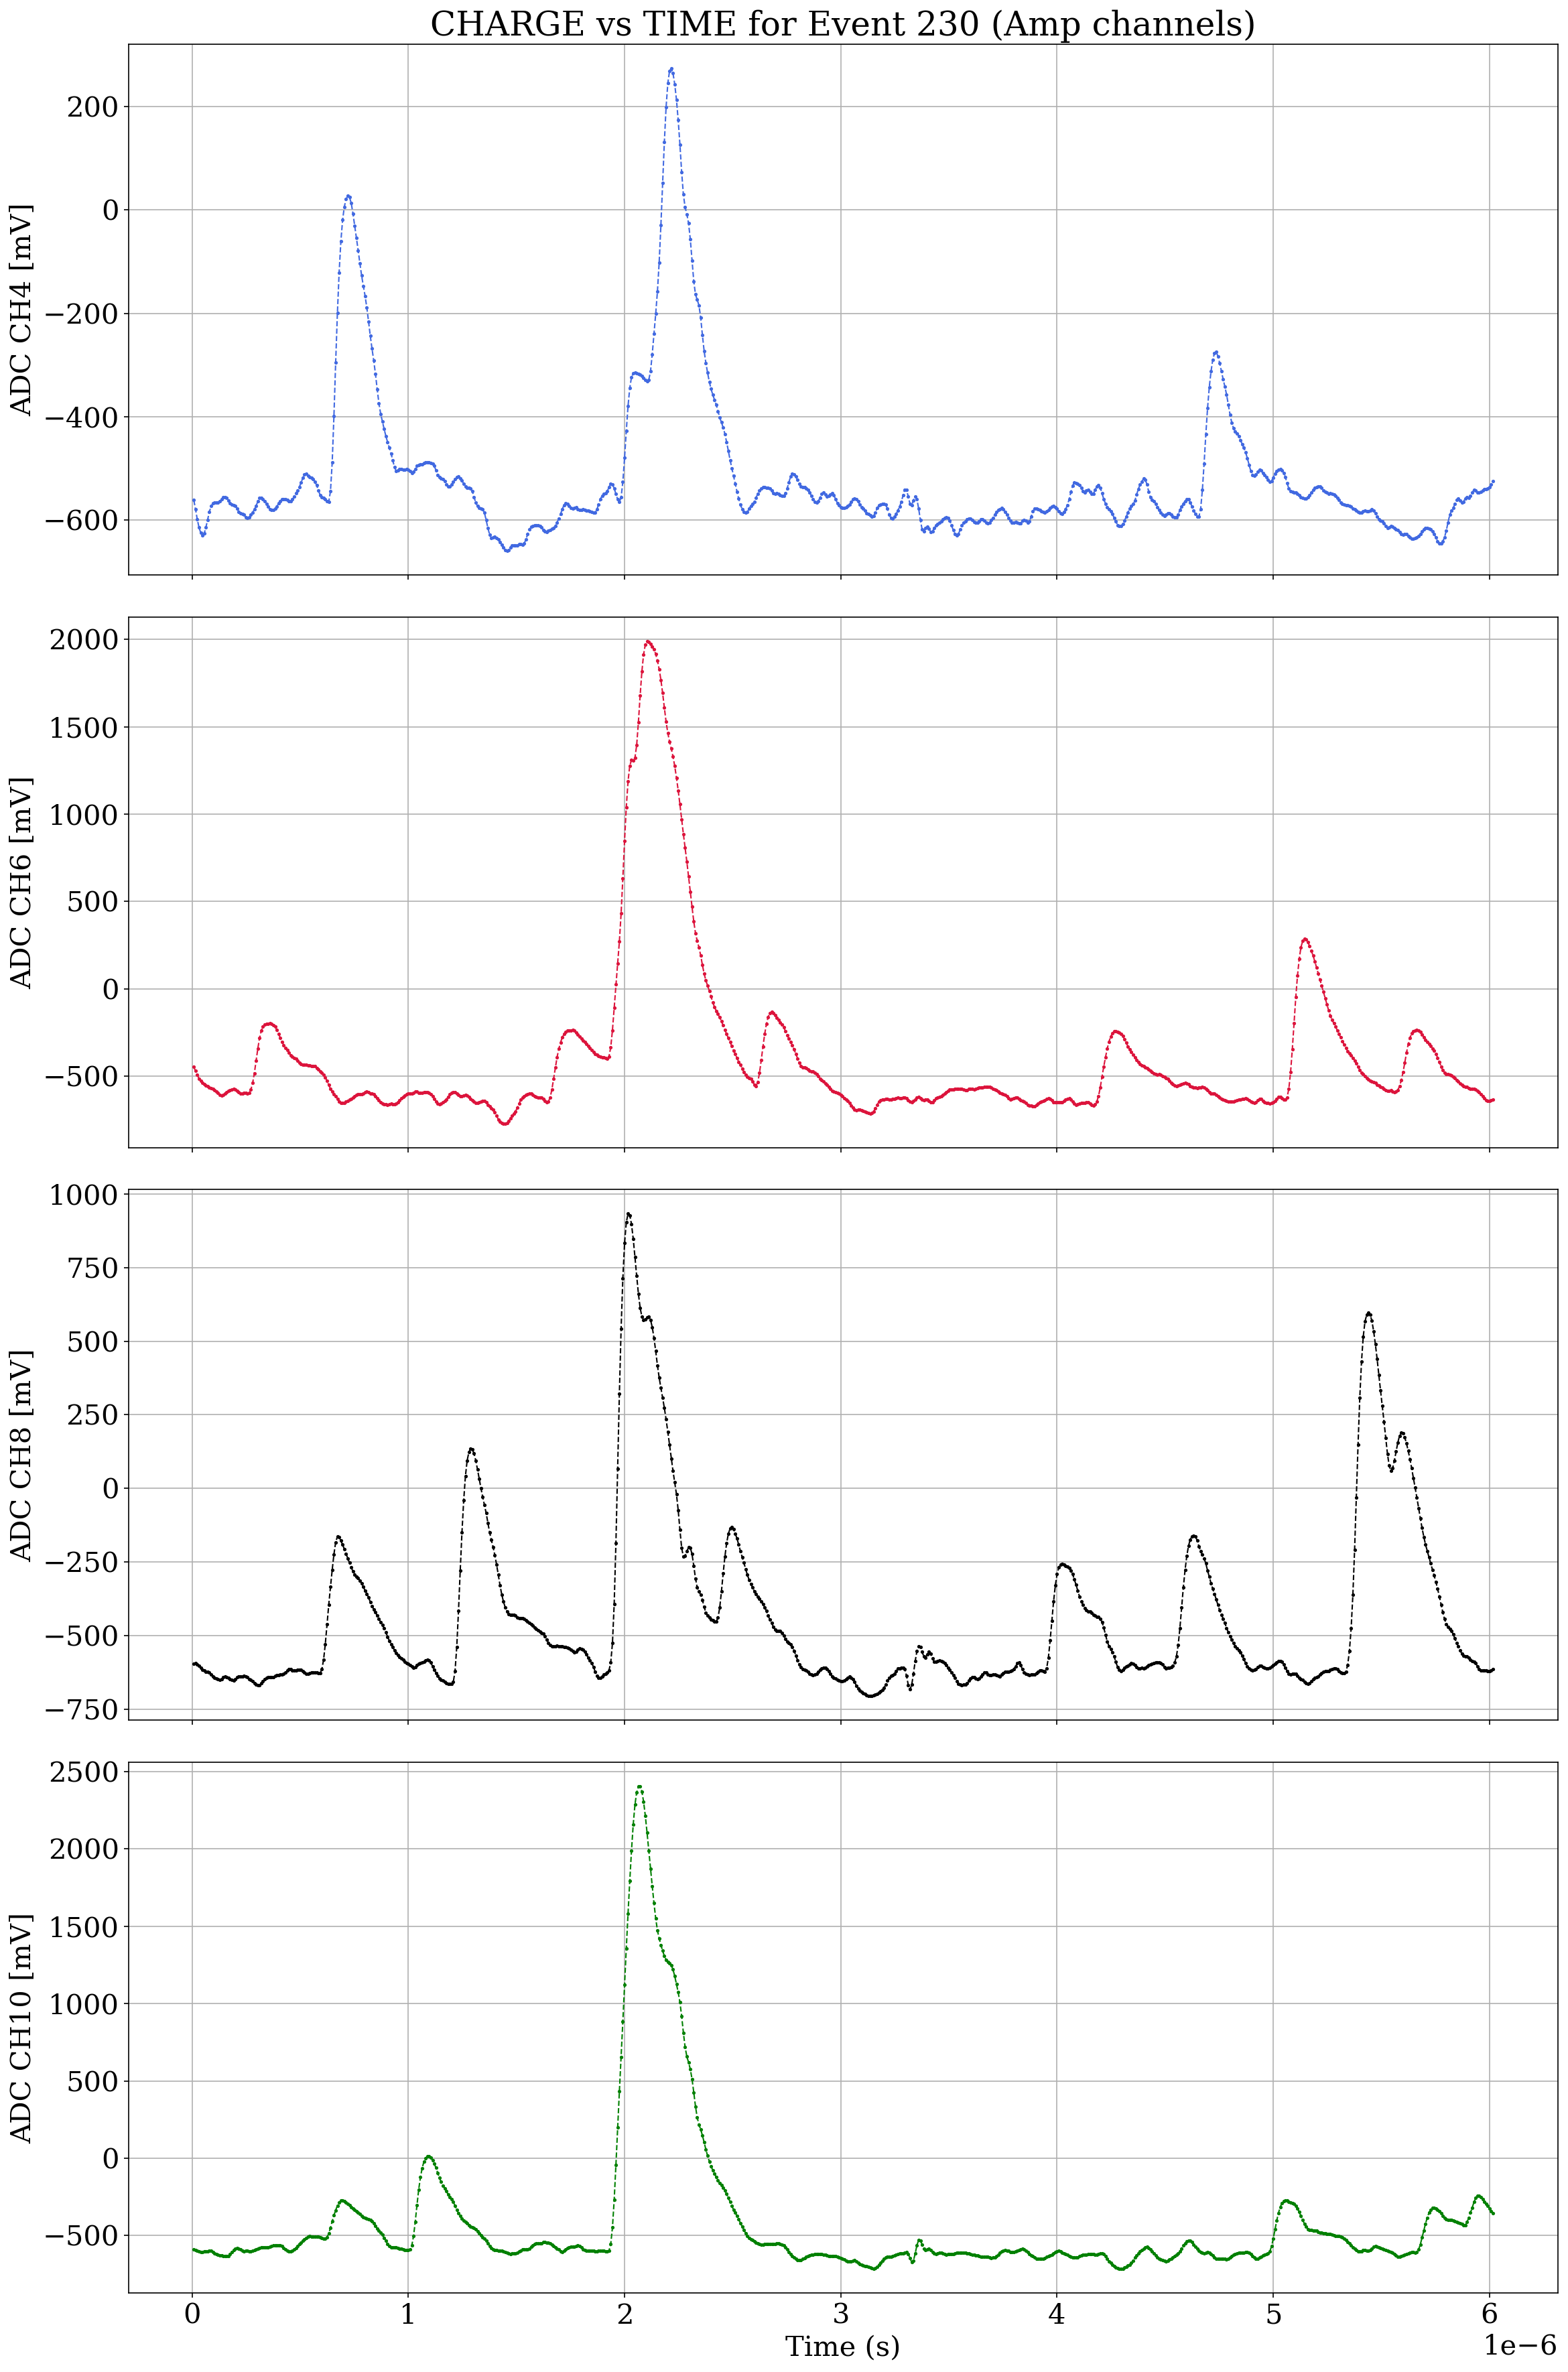

In [11]:
# Create subplots: 2 rows, 1 column

if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(16, len(Amp_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'CHARGE vs TIME for Event {event_list[selected_event]} (Amp channels)')

else:
    ax.set_title(f'CHARGE vs TIME for Event {event_list[selected_event]} (Amp channels)')

# Plot CHs
for i in range(len(Amp_channels)):

    if len(Amp_channels) > 1:
        ax = axs[i]

    ax.plot(df_event['TIME'].values, df_event[f'{Amp_channels[i]}'].values, marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'{Amp_channels[i]}')
    ax.set_ylabel(f'ADC {Amp_channels[i]} [mV]')
    ax.grid(True)

if len(Amp_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')
# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

##  Data filtering

In [12]:
# function to count number of peaks above threshold for one waveform
def count_high_peaks(group, threshold=1000):
    peak_count = 0
    for ch in Amp_channels:
        peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
        peak_count += len(peaks)
    return peak_count

# group by event (or event_time if that's more appropriate)
peak_counts = df.groupby("event").apply(count_high_peaks)

# keep only events with <= 5 peaks above 2000
valid_events = peak_counts[peak_counts <= 4].index

# filter the original dataframe
filtered_df = df[df["event"].isin(valid_events)]

# update the number of valid events
event_list  = filtered_df['event'].unique()
nevents     = len(event_list)
print(f'Filtered df nevents = {nevents}')

Filtered df nevents = 2294


/tmp/ipykernel_893684/1341809093.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_counts = df.groupby("event").apply(count_high_peaks)


##  Baseline calculation

In [13]:
# DEFINITION OF THE BASELINE WINDOW WITH HERE
window_width = 80


In [20]:
selected_ev = 200


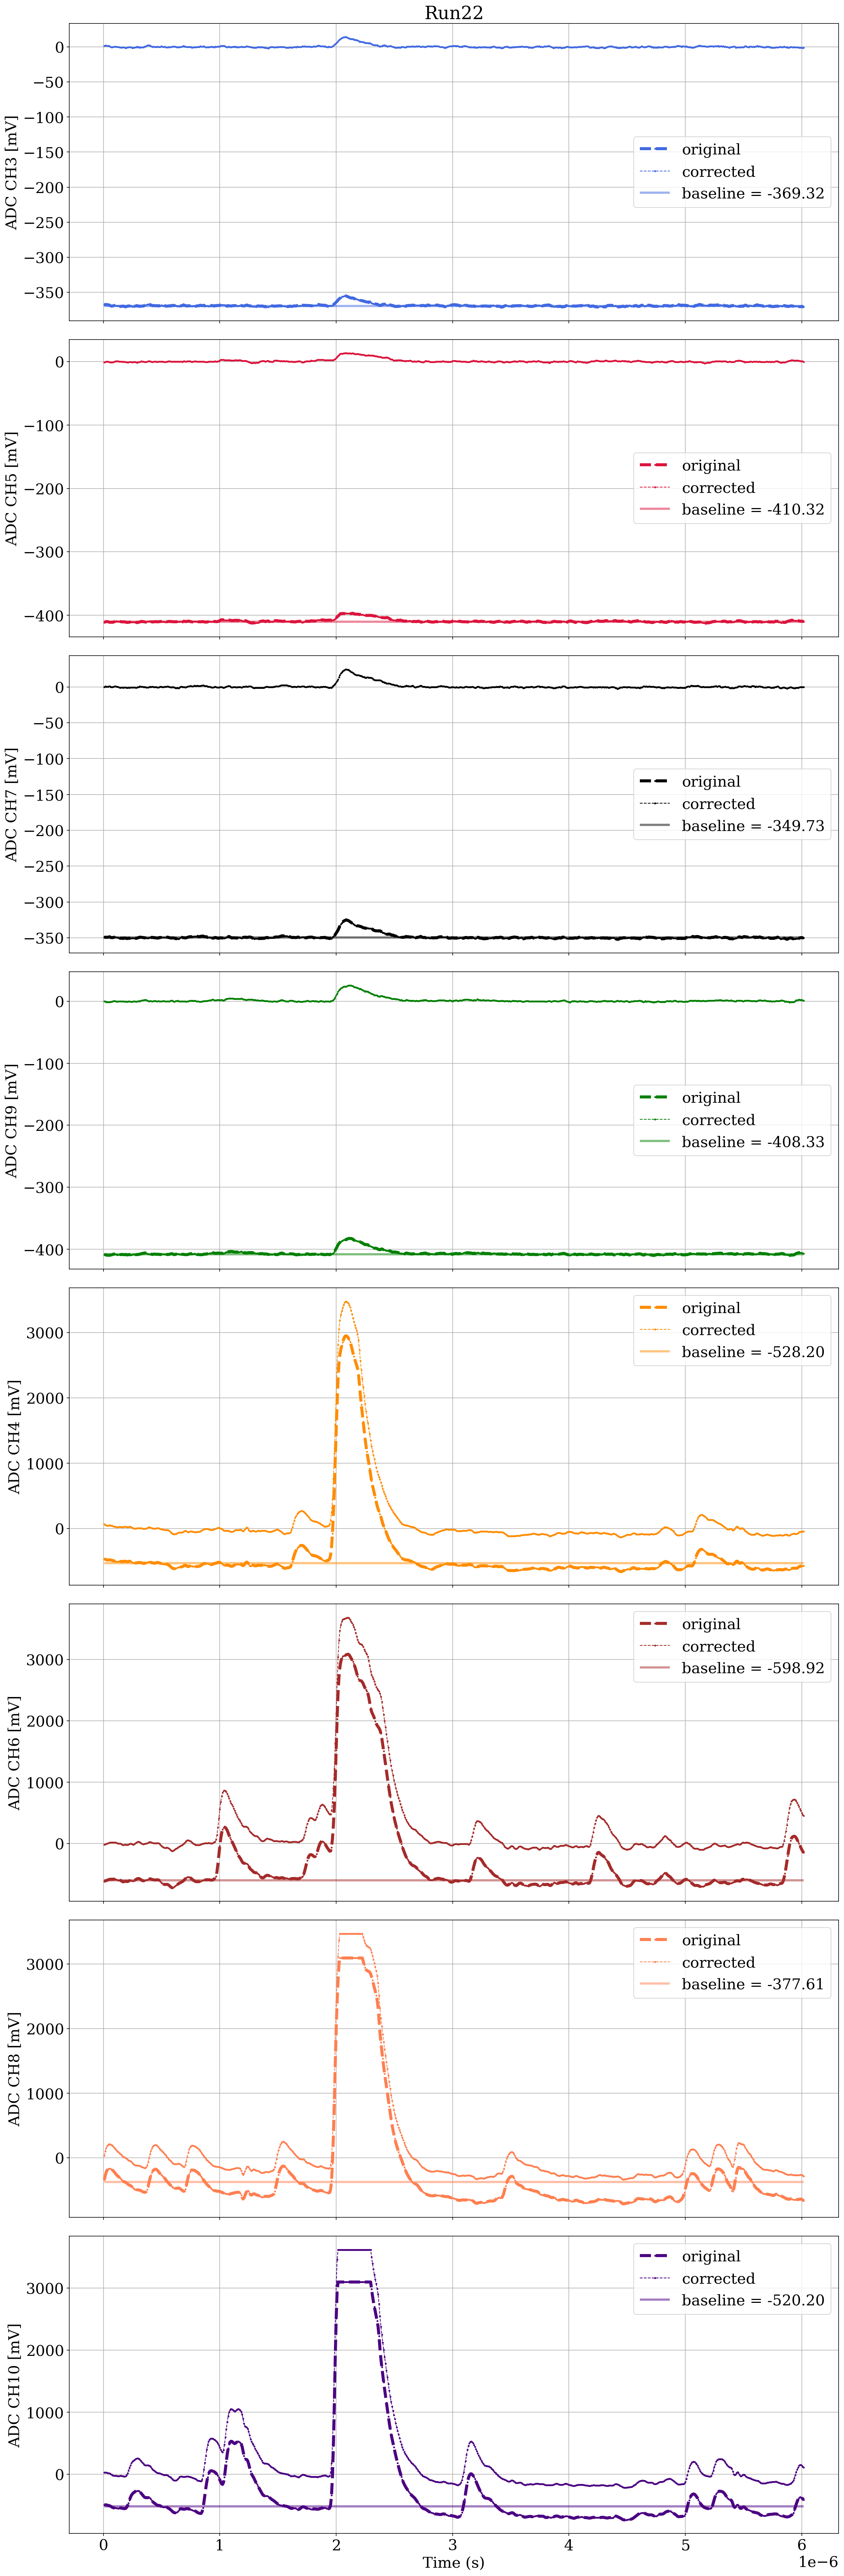

In [15]:
# Create subplots: 2 rows, 1 column

if len(all_channels) > 1:
    fig, axs = plt.subplots(len(all_channels), 1, figsize=(16, len(all_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(all_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(all_channels):

    if len(all_channels) > 1:
        ax = axs[i]

    voltage = filtered_df[f'{all_channels[i]}'].values

    t_matrix = time.reshape(nevents, -1)
    v_matrix = voltage.reshape(nevents, -1)
    v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)

    ax.plot(t_matrix[selected_ev], v_matrix[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=4, label=f'original')
    ax.plot(t_matrix[selected_ev], v_matrix_corrected[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'corrected')
    

    # start = max(window[selected_ev], 0)
    # end   = min(window[selected_ev] + window_width, len(v_matrix[0]))
    # ax.fill_between(time[start:end], 
    #                 min(v_matrix_corrected[selected_ev].min(), v_matrix[selected_ev].min()), 
    #                 max(v_matrix_corrected[selected_ev].max(), v_matrix[selected_ev].max()), 
    #                 color = colors[i], alpha = 0.3)

    ax.hlines(baselines[selected_ev], t_matrix[selected_ev].min(), t_matrix[selected_ev].max(), 
              color= colors[i],
              linewidth=3,
              alpha = 0.5,
              label = f'baseline = {baselines[selected_ev]:.2f}'
              )

    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

In [16]:
v_matrix_corrected[selected_ev].max()


3616.6455688476562

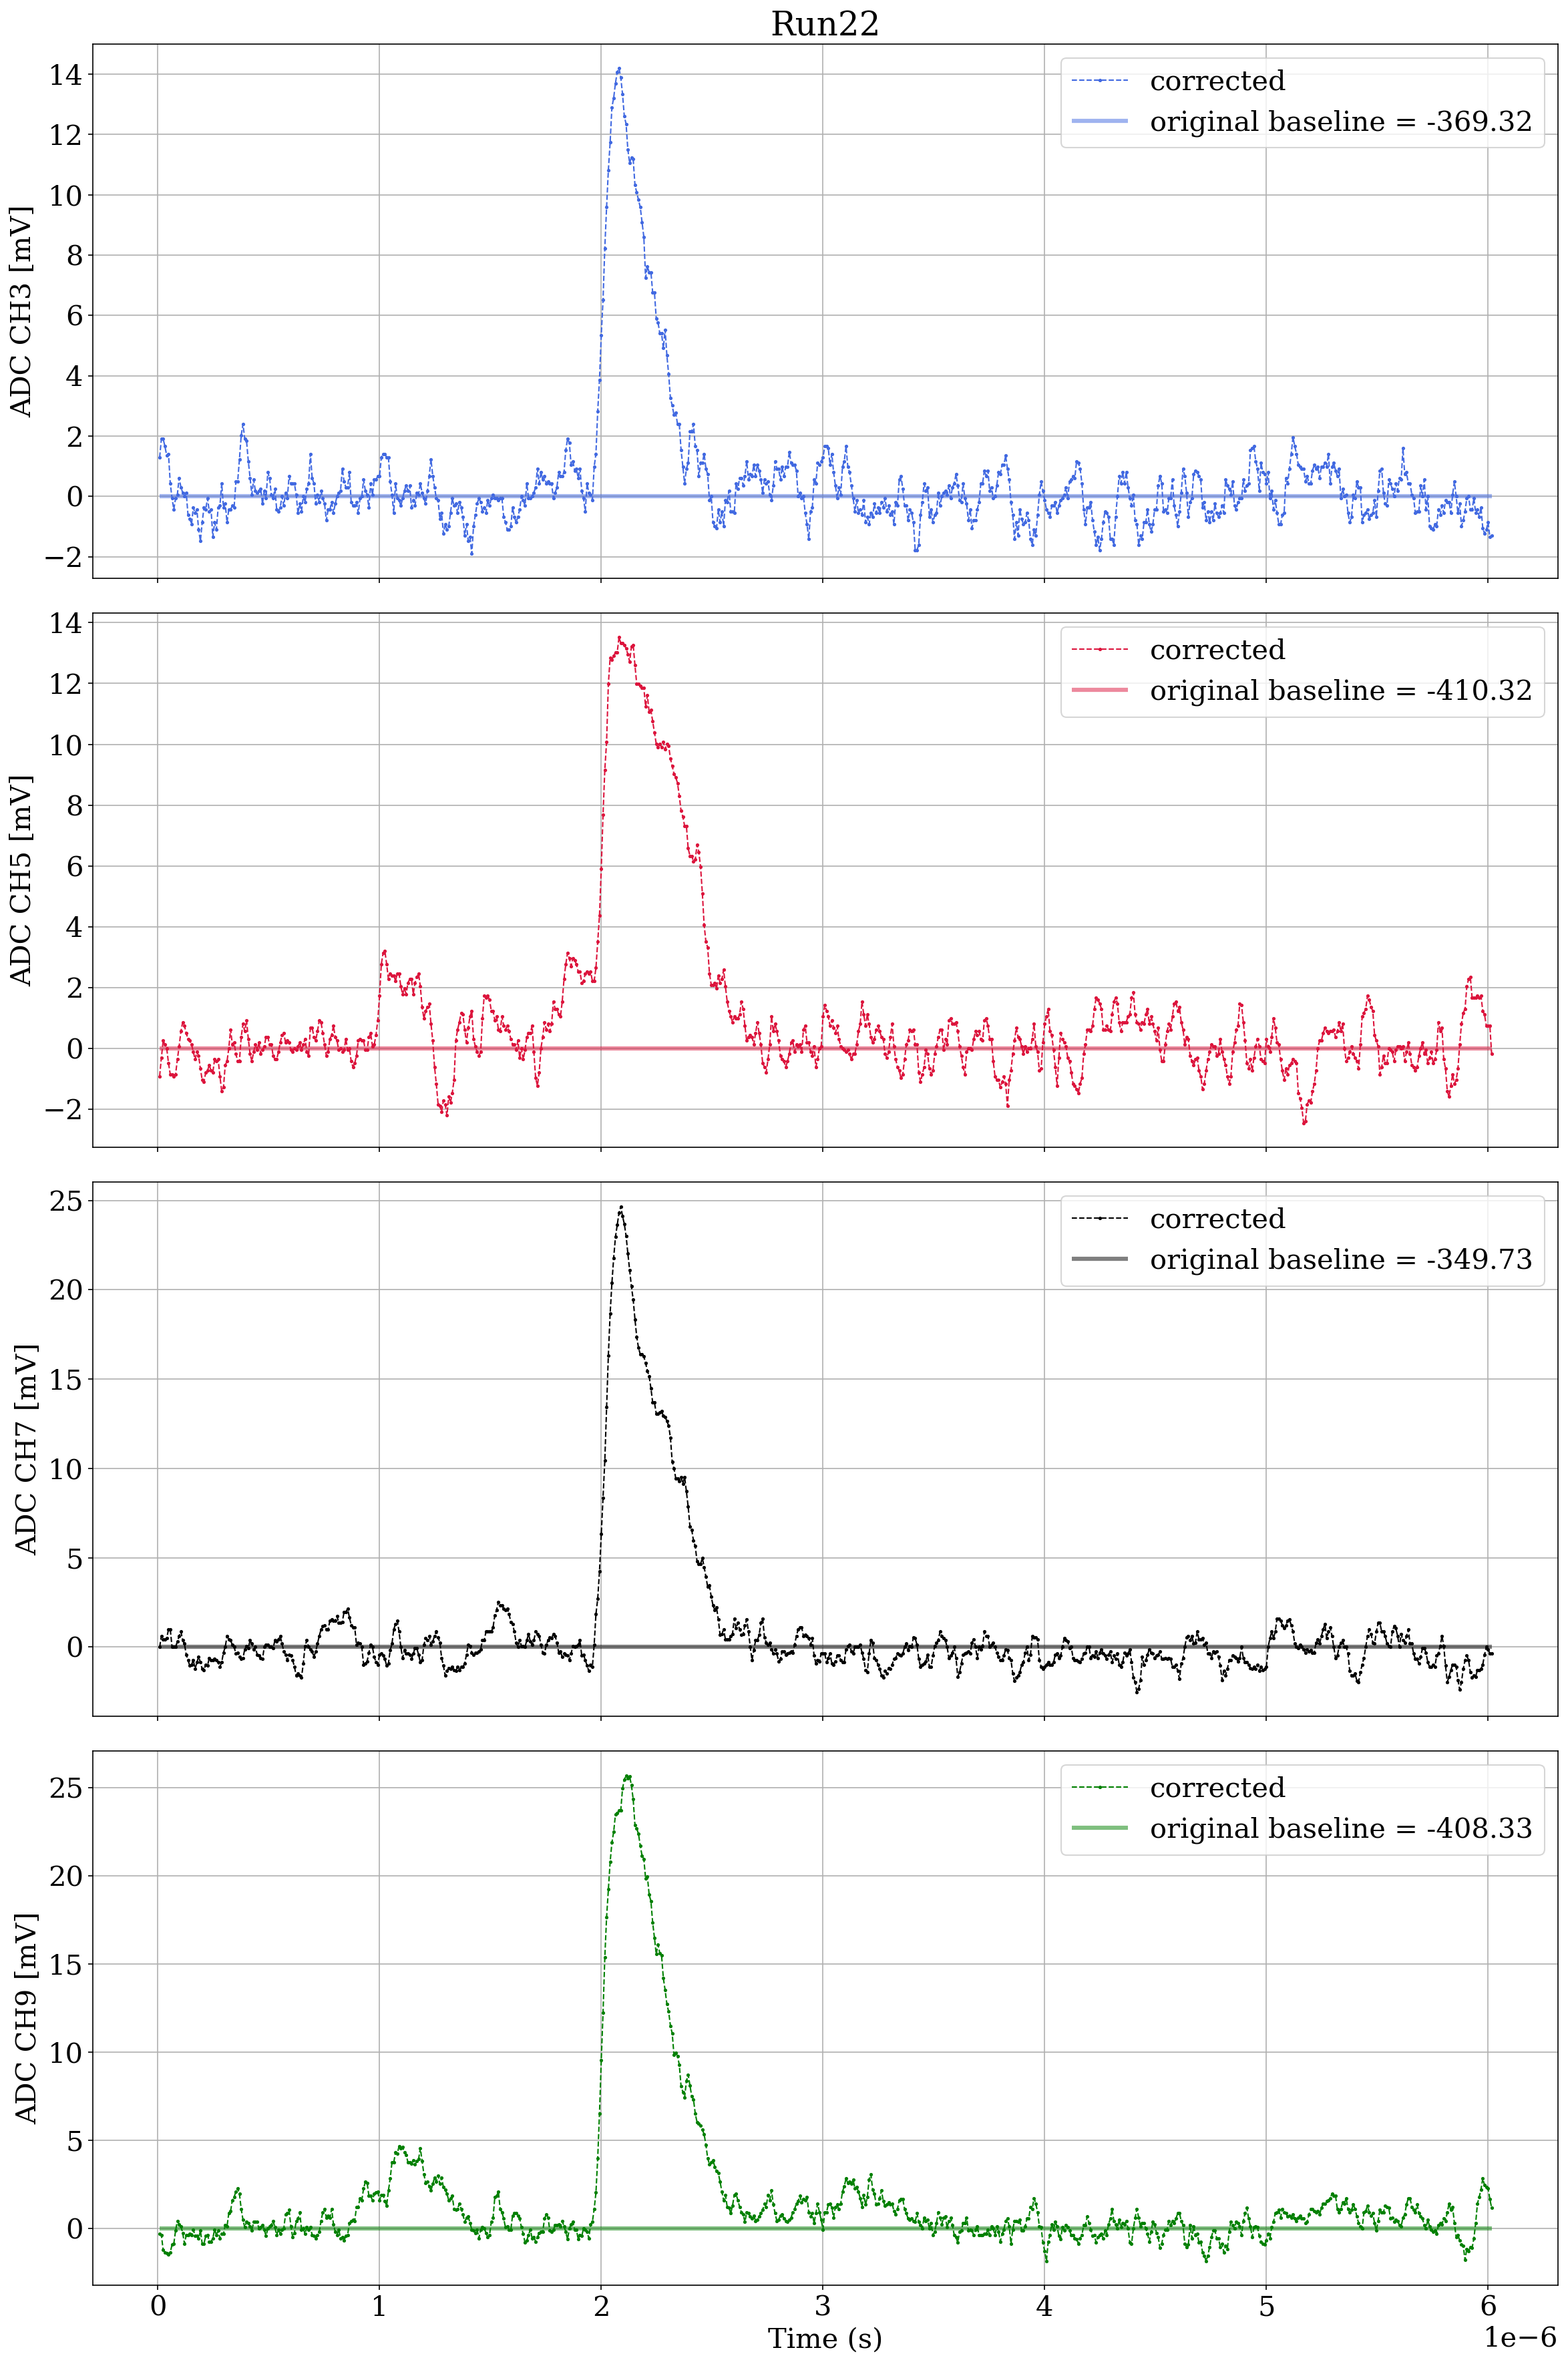

In [17]:
# Create subplots: 2 rows, 1 column

if len(noAmp_channels) > 1:
    fig, axs = plt.subplots(len(noAmp_channels), 1, figsize=(16, len(noAmp_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(noAmp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(noAmp_channels):

    if len(noAmp_channels) > 1:
        ax = axs[i]

    voltage = filtered_df[f'{noAmp_channels[i]}'].values

    t_matrix = time.reshape(nevents, -1)
    v_matrix = voltage.reshape(nevents, -1)
    v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)

    ax.plot(t_matrix[selected_ev], v_matrix_corrected[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'corrected')
    

    # start = max(window[selected_ev], 0)
    # end   = min(window[selected_ev] + window_width, len(v_matrix[0]))
    # ax.fill_between(time[start:end], 
    #                 v_matrix_corrected[selected_ev].min(), 
    #                 v_matrix_corrected[selected_ev].max(), 
    #                 color = colors[i], alpha = 0.3)


    # ax.hlines(baselines[selected_ev], 
    ax.hlines(0, 
              t_matrix[selected_ev].min(), t_matrix[selected_ev].max(), 
              color= colors[i],
              linewidth=3,
              alpha = 0.5,
              label = f'original baseline = {baselines[selected_ev]:.2f}'
              )

    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

In [18]:
v_matrix_corrected[selected_ev].max()

25.712860107421875

##  Amplification

In [19]:
t_matrix = filtered_df['TIME'].values.reshape(nevents, -1)
time = t_matrix[0]

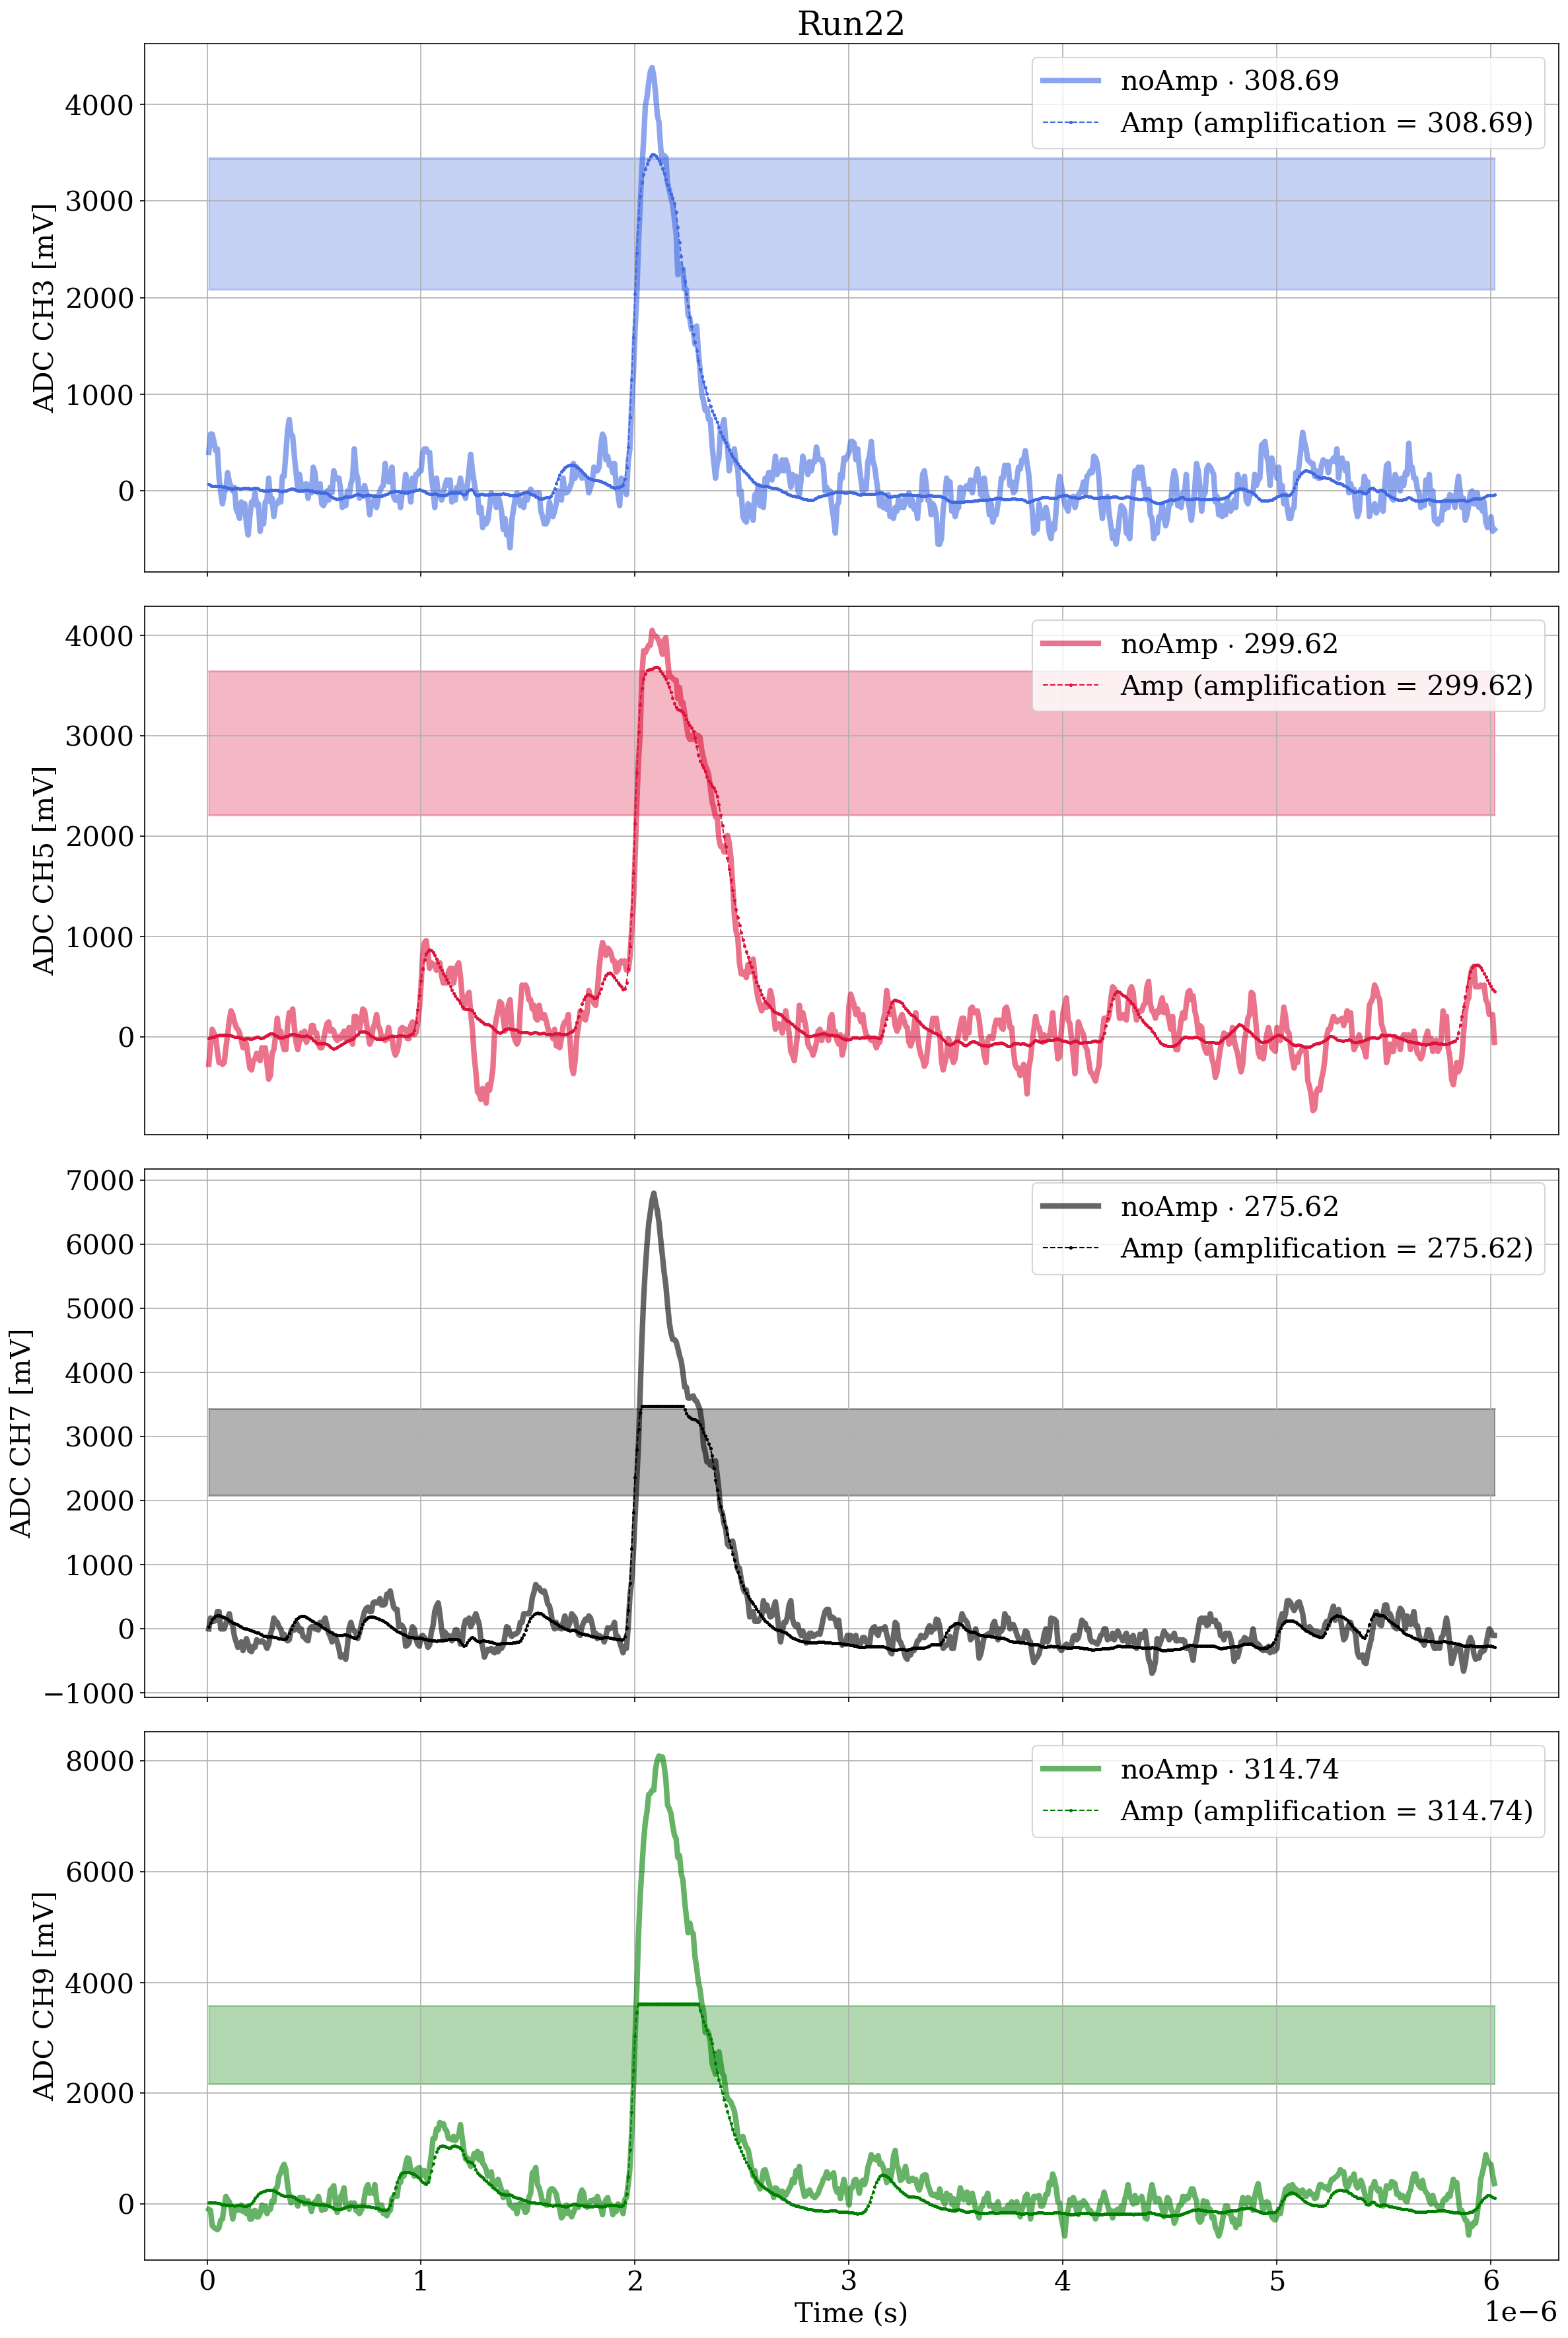

In [20]:
# Create subplots: 2 rows, 1 column

if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(16, len(Amp_channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(Amp_channels):

    if len(Amp_channels) > 1:
        ax = axs[i]

    voltage_noAmp   = filtered_df[f'{noAmp_channels[i]}'].values
    voltage_Amp     = filtered_df[f'{Amp_channels[i]}'].values

    t_matrix        = time.reshape(nevents, -1)
    
    v_matrix_noAmp  = voltage_noAmp.reshape(nevents, -1)
    v_matrix_Amp    = voltage_Amp.reshape(nevents, -1)

    v_matrix_corrected_noAmp, baselines_noAmp, window_noAmp = cig.BaselineCorrection(v_matrix_noAmp, window=window_width)
    v_matrix_corrected_Amp, baselines_Amp, window_Amp       = cig.BaselineCorrection(v_matrix_Amp, window=window_width)

    Amp_min_th      = v_matrix_corrected_Amp[selected_ev].max()*0.6
    Amp_saturation  = v_matrix_corrected_Amp[selected_ev].max()*0.99

    amp_mask    = (v_matrix_corrected_Amp[selected_ev] > Amp_min_th) & (v_matrix_corrected_Amp[selected_ev] < Amp_saturation) # don't get saturation values either
    # Avoid division by zero or tiny denominators
    safe_mask = np.abs(v_matrix_corrected_noAmp[selected_ev]) > 1e-6
    valid_mask = amp_mask & safe_mask

    amp         = (v_matrix_corrected_Amp[selected_ev][valid_mask]/v_matrix_corrected_noAmp[selected_ev][valid_mask]).mean()
    # amp = np.nanmean(v_matrix_corrected_Amp/v_matrix_corrected_noAmp, axis = 1).mean()

    ax.plot(t_matrix[selected_ev], amp*v_matrix_corrected_noAmp[selected_ev], marker='', linestyle='-',
                color= colors[i], markersize=3, alpha = 0.6, linewidth=4, label=fr'noAmp $\cdot$ {amp:.2f}')
    ax.plot(t_matrix[selected_ev], v_matrix_corrected_Amp[selected_ev], marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'Amp (amplification = {amp:.2f})')
    

    ax.fill_between(time, Amp_min_th, Amp_saturation, 
                    color = colors[i], alpha = 0.3)

    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

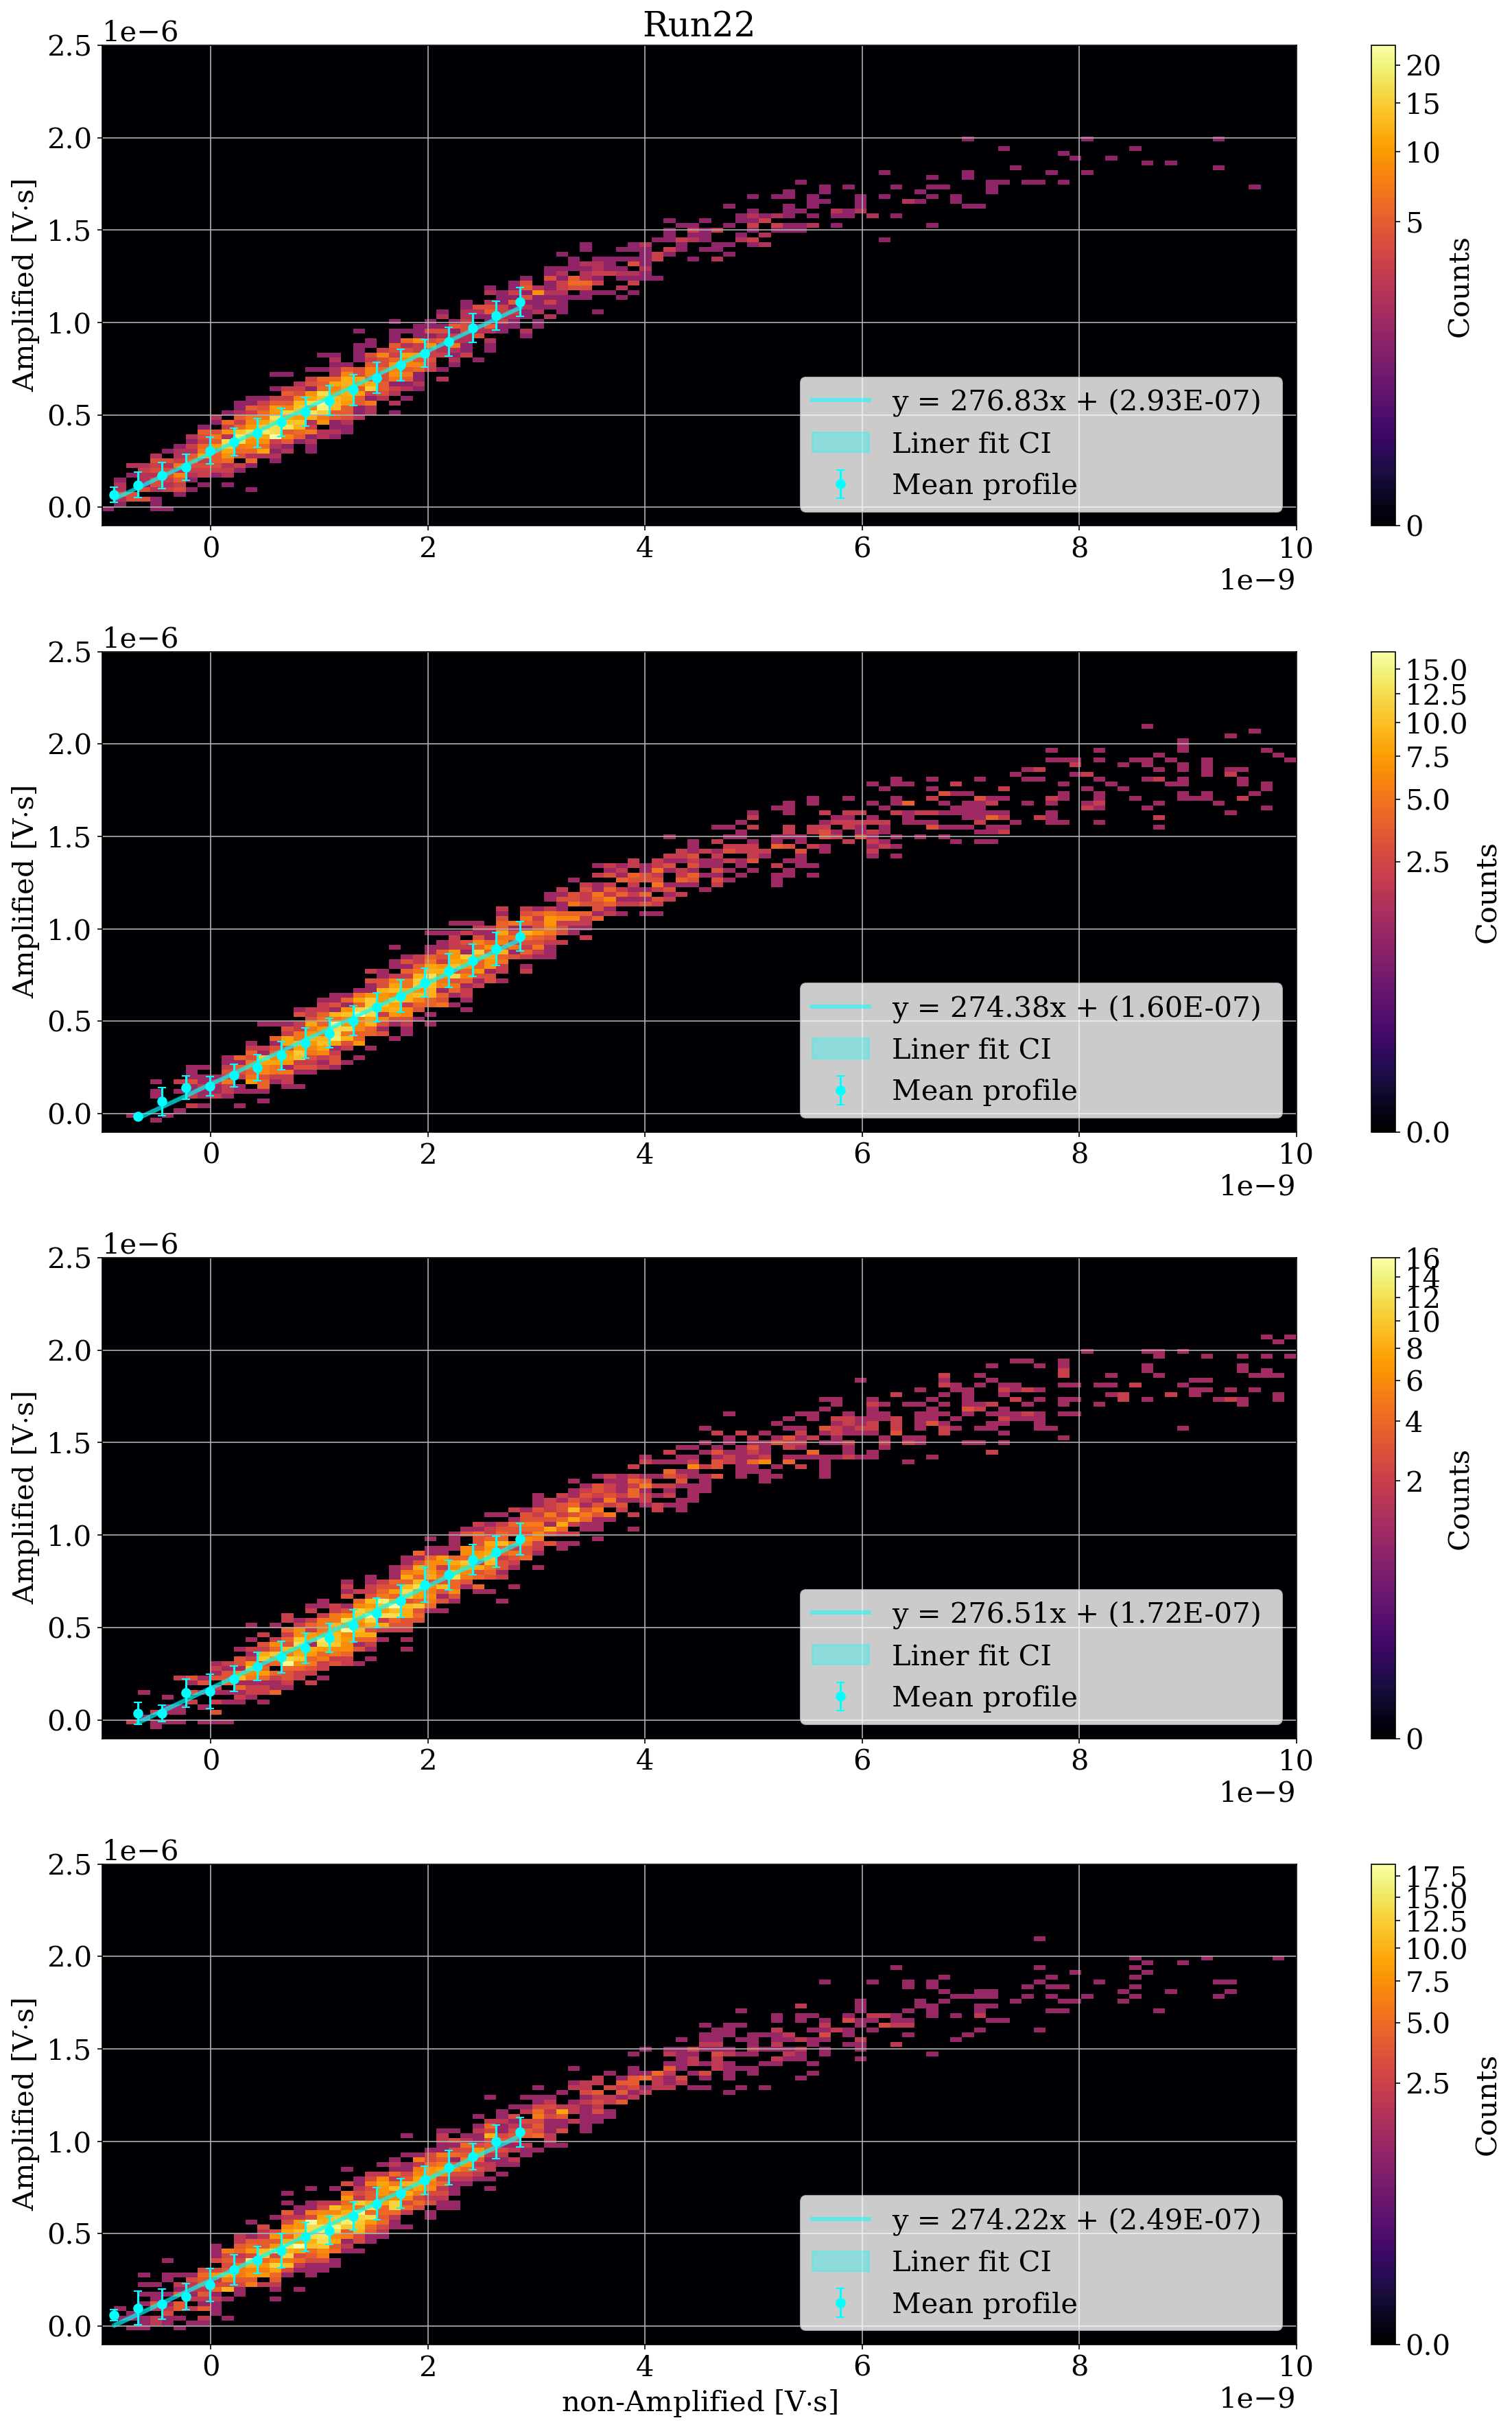

In [77]:
# Create subplots: 2 rows, 1 column

if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(16, len(Amp_channels)*6), dpi=150, sharex=False)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')

amp_factors = {}

time    = filtered_df['TIME'].values

# define the range of x (noAmp_amplitude) to include
# x_min, x_max = 0, 20
# x_min, x_max = -5, 20
# x_min, x_max = -np.inf, np.inf
# x_min, x_max = -1e10, 15e-9

# xrange = (0, 20)
# yrange = (0, 4000)
xrange = (-1e-9, 1.e-8)
yrange = (-1e-7, 2.5e-6)
# Fit 
# fit_range = (2.5, 10)
fit_range = (-1e-9, 0.3e-8)

# Plot CHs
for i, ch in enumerate(Amp_channels):

    if len(Amp_channels) > 1:
        ax = axs[i]

    voltage_noAmp   = filtered_df[f'{noAmp_channels[i]}'].values
    voltage_Amp     = filtered_df[f'{Amp_channels[i]}'].values

    time_mask = (1.8e-6 <= time) & (time <= 3e-6)
    # time_mask = (-10.8 <= time) & (time <= 30)
    t_matrix        = time[time_mask].reshape(nevents, -1)
    
    v_matrix_noAmp  = voltage_noAmp[time_mask].reshape(nevents, -1)
    v_matrix_Amp    = voltage_Amp[time_mask].reshape(nevents, -1)

    # v_matrix_corrected_noAmp, baselines_noAmp, window_noAmp = cig.BaselineCorrection(v_matrix_noAmp, window=window_width)
    # v_matrix_corrected_Amp, baselines_Amp, window_Amp       = cig.BaselineCorrection(v_matrix_Amp, window=window_width)

    # v_matrix_corrected_noAmp    = v_matrix_noAmp 

    v_matrix_corrected_noAmp    = v_matrix_noAmp - fixBaselines_noAmp[f'CH{i+1}']
    v_matrix_corrected_Amp      = v_matrix_Amp - fixBaselines_Amp[f'CH{i+1}']

    # v_matrix_corrected_noAmp = v_matrix_noAmp
    # v_matrix_corrected_Amp   = v_matrix_Amp


    Amp_amplitude = np.trapz(v_matrix_corrected_Amp*1e-3,
                      x = t_matrix
                      ,axis = 1)

    noAmp_amplitude = np.trapz(v_matrix_corrected_noAmp*1e-3,
                      x = t_matrix
                      ,axis = 1)
    

    # maxAmp_idx = np.argmax(v_matrix_corrected_Amp, axis=1)  # index of peak in Amp waveform
    # row_idx    = np.arange(nevents)                         # 0,1,2,... for advanced indexing

    # Amp_amplitude   = v_matrix_corrected_Amp[row_idx, maxAmp_idx]
    # noAmp_amplitude = v_matrix_corrected_noAmp[row_idx, maxAmp_idx]


    # noAmp_amplitude   = v_matrix_corrected_noAmp.max(axis=1)  # (nevents,)
    # Amp_amplitude     = v_matrix_corrected_Amp.max(axis=1)  # (nevents,)

    # noAmp_amplitude   = v_matrix_noAmp.max(axis=1) - v_matrix_noAmp.min(axis=1) # (nevents,)
    # Amp_amplitude     = v_matrix_Amp.max(axis=1) - v_matrix_Amp.min(axis=1) # (nevents,)

    # mask the data to include only that x-range
    # mask = (noAmp_amplitude >= x_min) & (noAmp_amplitude <= x_max)
    # mask = (noAmp_amplitude >= -np.inf) 
    x_vals = noAmp_amplitude
    y_vals = Amp_amplitude


    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hist, _, _, img = ax.hist2d(x_vals, y_vals, bins=[100, 100], 
                                range=[xrange, yrange],
                                cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(img, ax=ax, label="Counts")

    # Mean profile
    bins = 50
    mean, xedges, _ = binned_statistic(x_vals, y_vals, statistic='mean', bins=bins, range=xrange)
    std, _, _ = binned_statistic(x_vals, y_vals, statistic='std', bins=bins, range=xrange)
    xcenters = 0.5 * (xedges[1:] + xedges[:-1])

    # Overlay mean ± std
    # ax.plot(xcenters, mean, color='white', lw=2, label='Mean profile')
    # ax.fill_between(xcenters, mean-std, mean+std, color='white', alpha=0.3, lw=0)

    # Fit line
    fit_mask = (xcenters > fit_range[0]) & (xcenters < fit_range[1]) & np.isfinite(mean)
  
    x       = xcenters[fit_mask]
    y       = mean[fit_mask]
    yerr    = std[fit_mask]
    params, cov = np.polyfit(x, y, 1, cov=True)
    m, b        = params

    amp_factors[f'CH{i+1}'] = (m, b)
    # amp_factors[f'CH{i+1}'] = (m, 0)
    # amp_factors[f'CH{i+1}'] = m

    x_fit = np.linspace(x.min(), x.max(), 200)
    y_fit = m * x_fit + b
    y_fit_var = (x_fit**2) * cov[0,0] + cov[1,1] + 2 * x_fit * cov[0,1]
    y_fit_err = np.sqrt(y_fit_var)

    ax.plot(x_fit, y_fit, 'cyan', lw=3, alpha = 0.5, label=f'y = {m:.2f}x + ({b:.2E}) ')

    # Plot fit confidence band (before fit line so line is on top)
    ax.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err,
                    color='cyan', alpha=0.3, label=f'Liner fit CI')

    ax.errorbar(x, y
                ,yerr=yerr
                ,fmt=f'o' 
                ,color  ='cyan'
                ,label = fr'Mean profile' 
                ,capsize=3
                ,markersize = 6)


    ax.set_ylabel(fr'Amplified [V$\cdot$s]')
    # ax.set_ylabel(fr'Amplified [mV]')
    ax.grid(True)
    ax.legend(loc = 'lower right')

    # ax.set_xlim(x_min, x_max)
    # ax.set_ylim(0, 4000)

if len(all_channels) > 1:
    axs[-1].set_xlabel(r'non-Amplified [V$\cdot$s]')
    # axs[-1].set_xlabel(r'non-Amplified [mV]')
else:
    ax.set_xlabel(r'non-Amplified [V$\cdot$s]')
    # ax.set_xlabel(r'non-Amplified [mV]')

# Improve layout
plt.tight_layout()
plt.show()

In [78]:
x_vals.max()

1.9216958496093746e-08

In [79]:
xedges

array([-1.00e-09, -7.80e-10, -5.60e-10, -3.40e-10, -1.20e-10,  1.00e-10,
        3.20e-10,  5.40e-10,  7.60e-10,  9.80e-10,  1.20e-09,  1.42e-09,
        1.64e-09,  1.86e-09,  2.08e-09,  2.30e-09,  2.52e-09,  2.74e-09,
        2.96e-09,  3.18e-09,  3.40e-09,  3.62e-09,  3.84e-09,  4.06e-09,
        4.28e-09,  4.50e-09,  4.72e-09,  4.94e-09,  5.16e-09,  5.38e-09,
        5.60e-09,  5.82e-09,  6.04e-09,  6.26e-09,  6.48e-09,  6.70e-09,
        6.92e-09,  7.14e-09,  7.36e-09,  7.58e-09,  7.80e-09,  8.02e-09,
        8.24e-09,  8.46e-09,  8.68e-09,  8.90e-09,  9.12e-09,  9.34e-09,
        9.56e-09,  9.78e-09,  1.00e-08])

In [80]:
mean, xedges, _ = binned_statistic(x_vals, y_vals, statistic='mean', bins=bins, range=xrange)


In [81]:
# # Create subplots: 2 rows, 1 column
# # intercepts =  [-244.90, -100.78, -252.32, -203.72]
# # intercepts =  [99422.82, 97024.79, 83503.72, 110797.10]

# if len(Amp_channels) > 1:
#     fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(16, len(Amp_channels)*6), dpi=150, sharex=True)
# else:
#     fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

# if len(Amp_channels) > 1:
#     axs[0].set_title(f'{run}')
# else:
#     ax.set_title(f'{run}')

# time    = filtered_df['TIME'].values

# # define the range of x (noAmp_amplitude) to include
# # x_min, x_max = 0, 20
# # x_min, x_max = -5, 20
# x_min, x_max = -np.inf, np.inf
# # x_min, x_max = -1e10, 6e-9

# # Plot CHs
# for i, ch in enumerate(Amp_channels):

#     if len(Amp_channels) > 1:
#         ax = axs[i]

#     voltage_noAmp   = filtered_df[f'{noAmp_channels[i]}'].values
#     voltage_Amp     = filtered_df[f'{Amp_channels[i]}'].values

#     time_mask = (1.8e-6 <= time) & (time <= 3e-6)
#     # time_mask = (-10.8 <= time) & (time <= 30)
#     t_matrix        = time[time_mask].reshape(nevents, -1)
    
#     v_matrix_noAmp  = voltage_noAmp[time_mask].reshape(nevents, -1)
#     v_matrix_Amp    = voltage_Amp[time_mask].reshape(nevents, -1)

#     # v_matrix_corrected_noAmp, baselines_noAmp, window_noAmp = cig.BaselineCorrection(v_matrix_noAmp, window=window_width)

#     v_matrix_corrected_Amp, baselines_Amp, window_Amp       = cig.BaselineCorrection(v_matrix_Amp, window=window_width)

#     v_matrix_corrected_noAmp    = v_matrix_noAmp 
#     v_matrix_corrected_noAmp    = v_matrix_corrected_noAmp - (amp_factors[f'CH{i+1}'][1])/amp_factors[f'CH{i+1}'][0]

#     # v_matrix_corrected_noAmp    = v_matrix_noAmp - fixBaselines_noAmp[f'CH{i+1}']
#     # v_matrix_corrected_Amp      = v_matrix_Amp - fixBaselines_Amp[f'CH{i+1}']

#     # v_matrix_corrected_noAmp = v_matrix_noAmp
#     # v_matrix_corrected_Amp   = v_matrix_Amp


#     # Amp_amplitude = np.trapz(v_matrix_corrected_Amp*1e-3,
#     #                   x = t_matrix
#     #                   ,axis = 1)

#     # noAmp_amplitude = np.trapz(v_matrix_corrected_noAmp*1e-3,
#     #                   x = t_matrix
#     #                   ,axis = 1)
    

#     # maxAmp_idx = np.argmax(v_matrix_corrected_Amp, axis=1)  # index of peak in Amp waveform
#     # row_idx    = np.arange(nevents)                         # 0,1,2,... for advanced indexing

#     # Amp_amplitude   = v_matrix_corrected_Amp[row_idx, maxAmp_idx]
#     # noAmp_amplitude = v_matrix_corrected_noAmp[row_idx, maxAmp_idx]


#     noAmp_amplitude   = v_matrix_corrected_noAmp.max(axis=1)  # (nevents,)
#     Amp_amplitude     = v_matrix_corrected_Amp.max(axis=1)  # (nevents,)

#     # noAmp_amplitude   = v_matrix_noAmp.max(axis=1) - v_matrix_noAmp.min(axis=1) # (nevents,)
#     # Amp_amplitude     = v_matrix_Amp.max(axis=1) - v_matrix_Amp.min(axis=1) # (nevents,)

#     # mask the data to include only that x-range
#     mask = (noAmp_amplitude >= x_min) & (noAmp_amplitude <= x_max)
#     # mask = (noAmp_amplitude >= -np.inf) 
#     x_vals = noAmp_amplitude[mask]
#     y_vals = Amp_amplitude[mask]

#     # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
#     hist, xedges, yedges, img = ax.hist2d(x_vals, y_vals, bins=[100, 100], 
#                                 #    range=[[x_min, x_max], [y_vals.min(), y_vals.max()]],
#                                 #    range=[[xlim[i][0], xlim[i][1]], [y_vals.min(), y_vals.max()*1.1]],
#                                 #    range=[[0, x_vals.max()], [0, y_vals.max()]],
#                                 cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

#     fig.colorbar(img, ax=ax, label="Counts")

#     # Fit line
#     # fit_mask = (y_vals >= -2000) & (y_vals <= 0.6e-6)
#     fit_mask = (y_vals >= -2000) & (y_vals <= 2200)
#     # fit_mask = (y_vals >= 1000) & (y_vals <= 2500)
#     # fit_mask = (x_vals >= x_min) & (x_vals <= 10)
#     # fit_mask = (x_vals >= x_min) & (x_vals <= xlim[i][1]*1.02)
#     xx = x_vals[fit_mask]
#     yy = y_vals[fit_mask]

#     # points_per_bin  = len(xx) // 12
#     N               = 31
#     x, y            = mean_binning(xx, yy, N=N)
#     x_std, y_std    = std_binning(xx, yy, N=N)
#     points_per_bin  = len(xx) // N  # number of points per bin
#     xerr            = x_std / np.sqrt(points_per_bin)
#     yerr            = y_std / np.sqrt(points_per_bin)

#     params, cov = np.polyfit(x, y, 1, cov=True)
#     m, b        = params

#     # amp_factors[f'CH{i+1}'] = (m, b)
#     # amp_factors[f'CH{i+1}'] = (m, 0)
#     # amp_factors[f'CH{i+1}'] = m

#     x_fit = np.linspace(x.min(), x.max(), 200)
#     y_fit = m * x_fit + b
#     y_fit_var = (x_fit**2) * cov[0,0] + cov[1,1] + 2 * x_fit * cov[0,1]
#     y_fit_err = np.sqrt(y_fit_var)

#     ax.plot(x_fit, y_fit, 'blue', lw=1, label=f'y = {m:.2f}x + ({b:.2f}) ')

#     # Plot fit confidence band (before fit line so line is on top)
#     ax.fill_between(x_fit, y_fit - y_fit_err, y_fit + y_fit_err,
#                     color='blue', alpha=0.3, label=f'Liner fit CI')

#     ax.errorbar(x, y
#                 ,xerr=xerr
#                 ,yerr=yerr
#                 ,fmt=f'o' 
#                 ,color  ='darkblue'
#                 ,label = fr'Mean value' 
#                 ,capsize=3
#                 ,markersize = 4)


#     # ax.set_ylabel(fr'Amplified [V$\cdot$s]')
#     ax.set_ylabel(fr'Amplified [mV]')
#     ax.grid(True)
#     ax.legend(loc = 'lower right')

#     # ax.set_xlim(x_min, x_max)
#     # ax.set_ylim(0, 4000)

# if len(all_channels) > 1:
#     # axs[-1].set_xlabel(r'non-Amplified [V$\cdot$s]')
#     axs[-1].set_xlabel(r'non-Amplified [mV]')
# else:
#     # ax.set_xlabel(r'non-Amplified [V$\cdot$s]')
#     ax.set_xlabel(r'non-Amplified [mV]')

# # Improve layout
# plt.tight_layout()
# plt.show()

##  Gain comparisson

In [82]:
amp_factors['CH1']

(276.8273121393516, 2.9293257968583347e-07)

In [83]:
# amp_factors = {'CH1':269,
#                'CH2':267,
#                'CH3':258,
#                'CH4':275
#                }

# amp_factors = {'CH1':277,
#                'CH2':269,
#                'CH3':263,
#                'CH4':284
#                }

temperature = f'{8}deg'

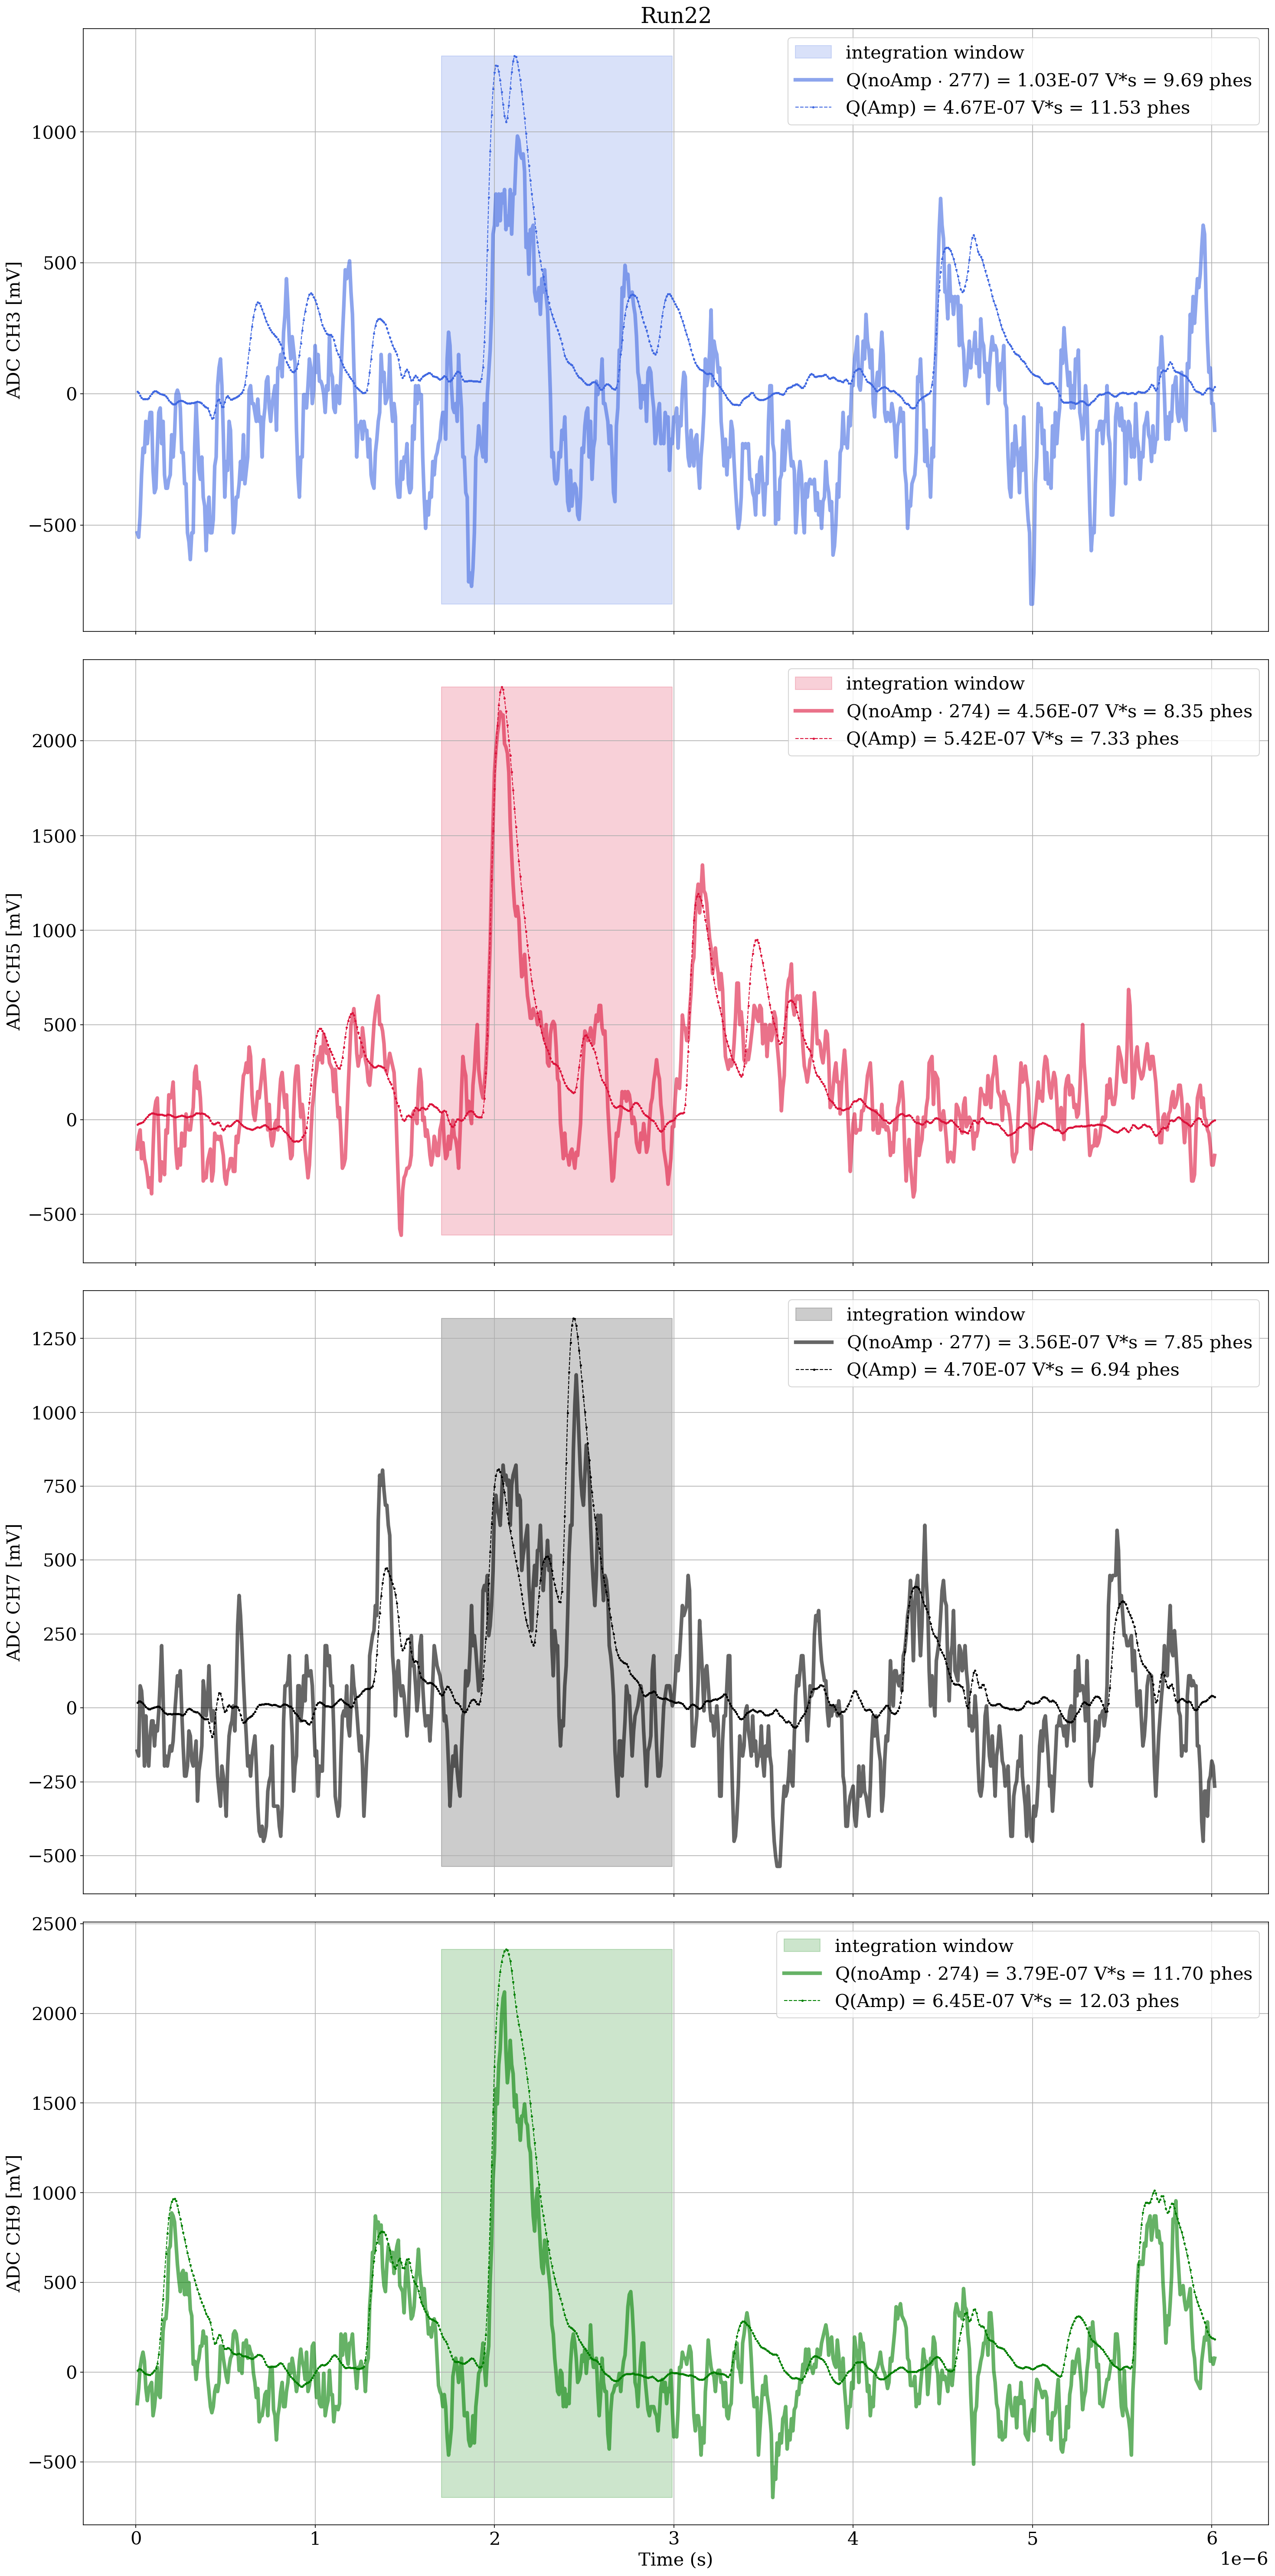

In [84]:
selected_ev = 540

if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(20, len(Amp_channels)*10), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(Amp_channels):

    if len(Amp_channels) > 1:
        ax = axs[i]

    voltage_noAmp   = filtered_df[f'{noAmp_channels[i]}'].values
    voltage_Amp     = filtered_df[f'{Amp_channels[i]}'].values

    t_matrix        = time.reshape(nevents, -1)
    
    v_matrix_noAmp  = voltage_noAmp.reshape(nevents, -1)
    v_matrix_Amp    = voltage_Amp.reshape(nevents, -1)

    # v_matrix_corrected_noAmp, baselines_noAmp, window_noAmp = cig.BaselineCorrection(v_matrix_noAmp, window=window_width)
    # v_matrix_corrected_Amp, baselines_Amp, window_Amp       = cig.BaselineCorrection(v_matrix_Amp, window=window_width)
    # v_matrix_corrected_Amp = v_matrix_corrected_Amp - intercepts[i]

    v_matrix_corrected_noAmp    = v_matrix_noAmp - fixBaselines_noAmp[f'CH{i+1}']
    v_matrix_corrected_Amp      = v_matrix_Amp - fixBaselines_Amp[f'CH{i+1}']

    v_noAmp = v_matrix_corrected_noAmp[selected_ev]
    v_Amp   = v_matrix_corrected_Amp[selected_ev]
    t = t_matrix[selected_ev]

    time_window = (1.7e-6 < t)  & (3e-6 > t)

    charge_noAmp = np.trapz(v_noAmp[time_window]*1e-3, 
                            x = t[time_window])
    charge_Amp = np.trapz(v_Amp[time_window]*1e-3, 
                            x = t[time_window])
    
    charge_noAmp_phes = cig.ChargeToPes(charge_noAmp, channel=i+1, temp = temperature, amplified = False, CHAmp=amp_factors)
    charge_Amp_phes = cig.ChargeToPes(charge_Amp, channel=i+1, temp = temperature, amplified = True, CHAmp=amp_factors)
    
    ax.fill_between(t[time_window], 
                    min(v_Amp.min(), (v_noAmp*amp_factors[f'CH{i+1}'][0]).min()), 
                    max(v_Amp.max(), (v_noAmp*amp_factors[f'CH{i+1}'][0]).max()), 
                    color = colors[i], alpha = 0.2, label = 'integration window')


    ax.plot(t_matrix[selected_ev], amp_factors[f'CH{i+1}'][0]*v_noAmp, marker='', linestyle='-',
                color= colors[i], markersize=3, alpha = 0.6, linewidth=4, 
                label=fr"Q(noAmp $\cdot$ {amp_factors[f'CH{i+1}'][0]:.0f}) = {(amp_factors[f'CH{i+1}'][0]*charge_noAmp):.2E} V*s = {charge_noAmp_phes:.2f} phes")
    ax.plot(t_matrix[selected_ev], v_Amp, marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'Q(Amp) = {charge_Amp:.2E} V*s = {charge_Amp_phes:.2f} phes')
    


    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

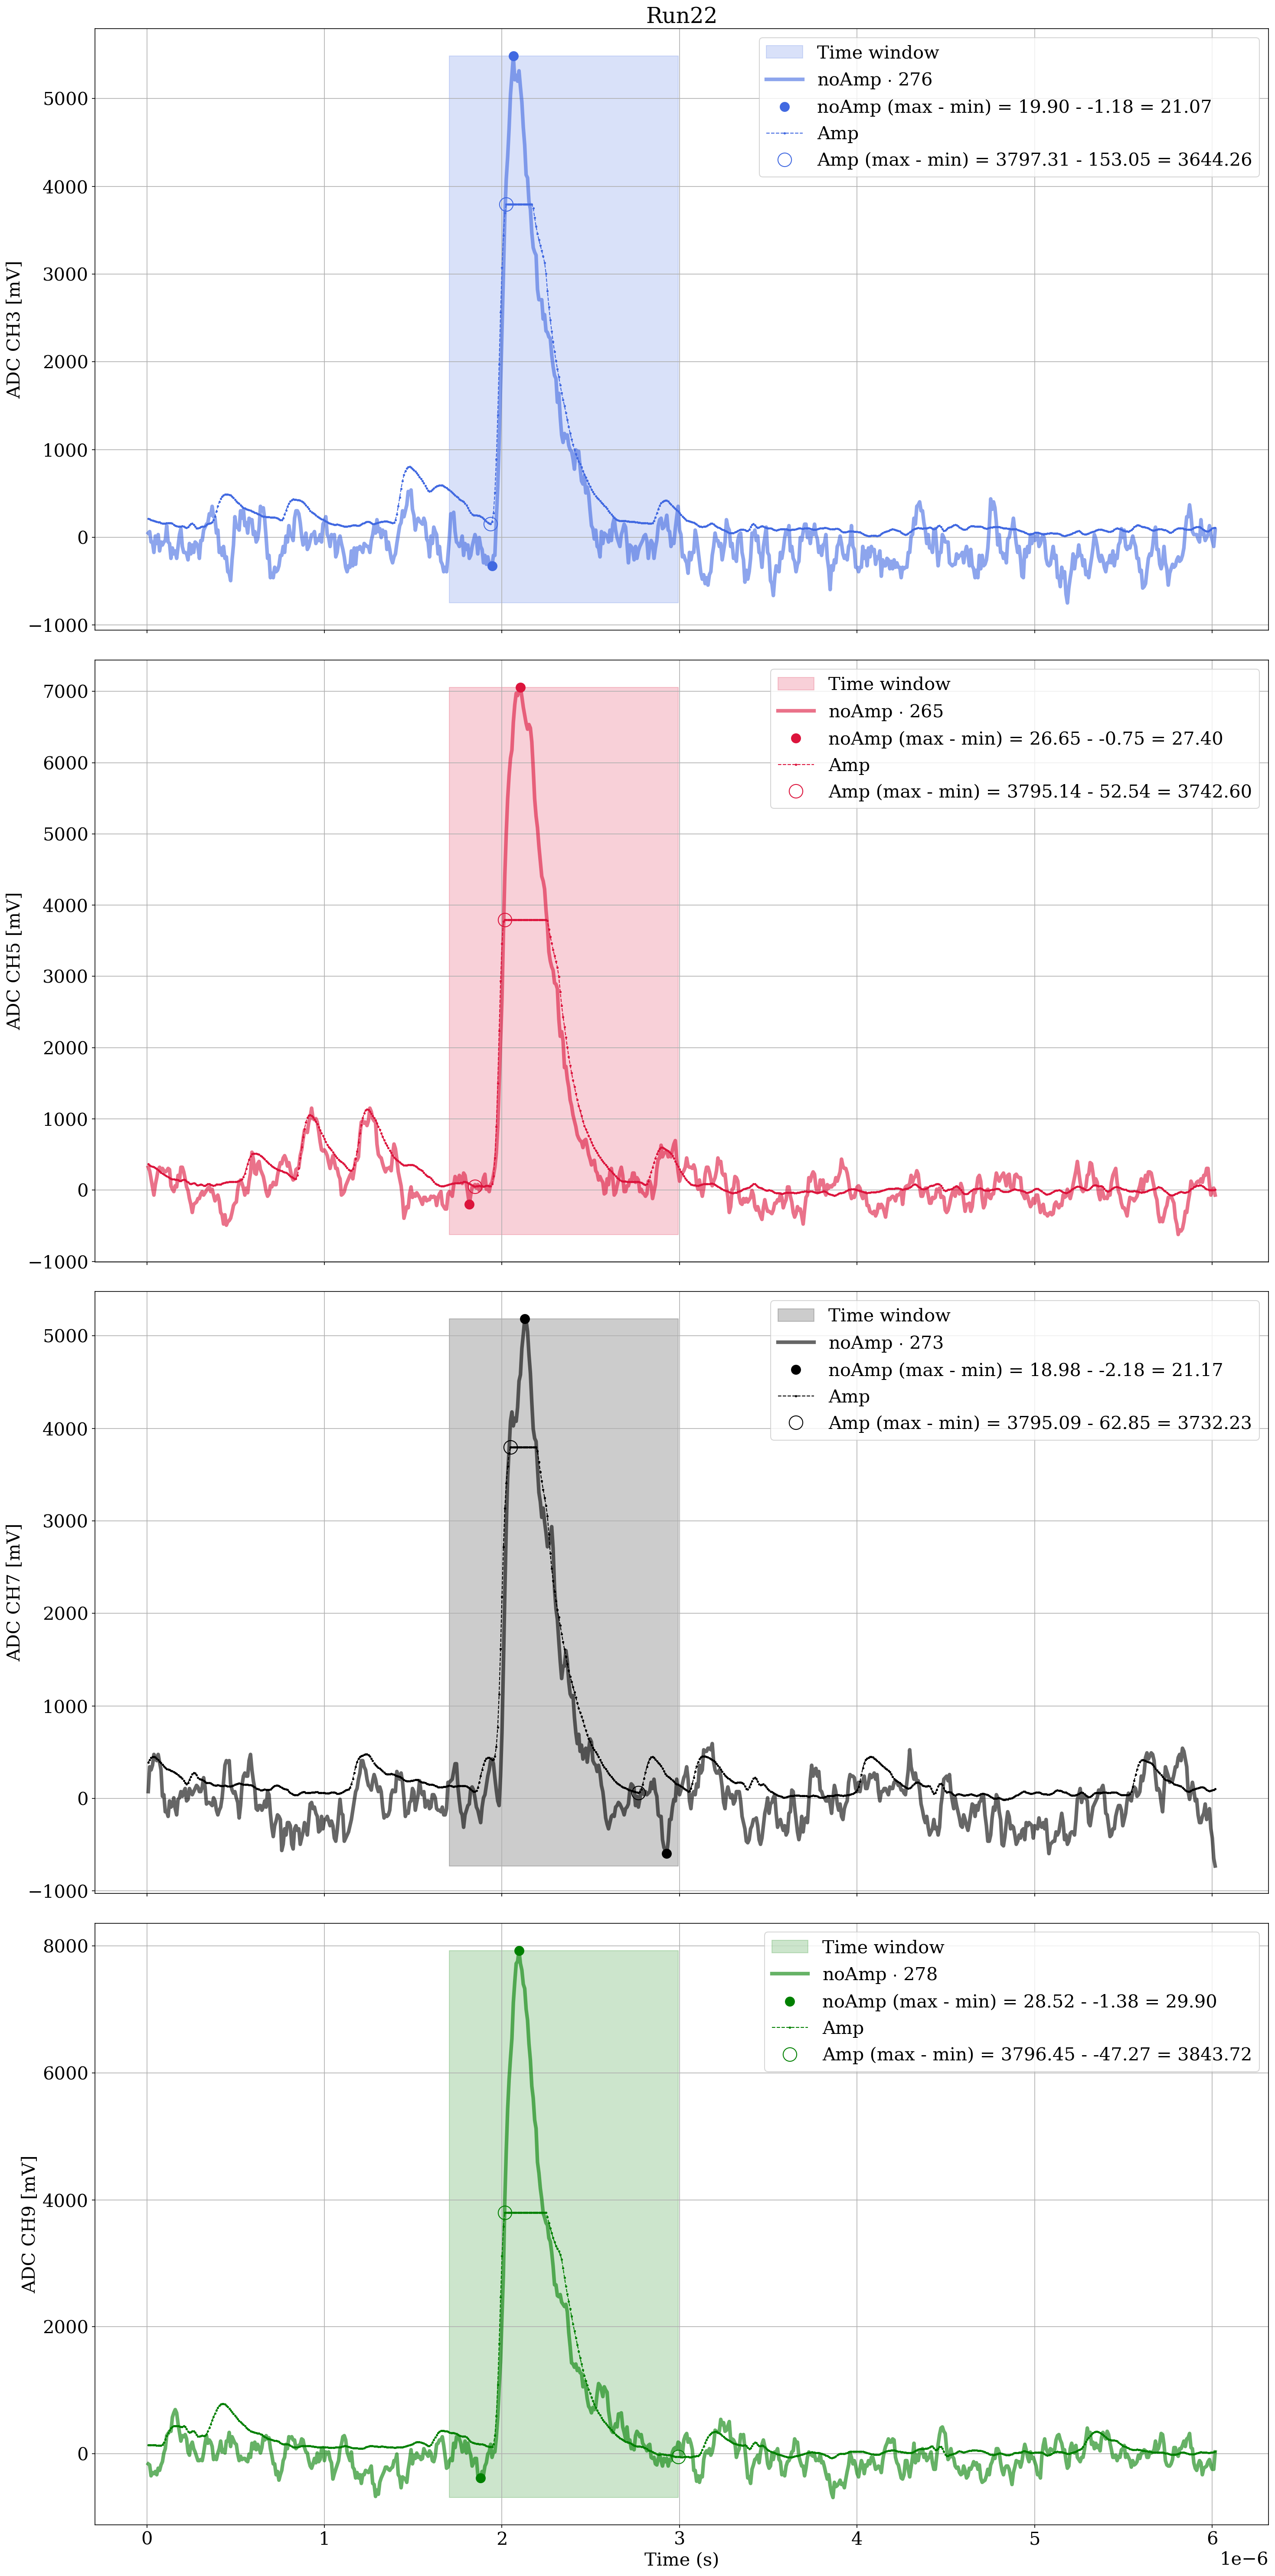

In [ ]:

if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(20, len(Amp_channels)*10), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(Amp_channels):

    if len(Amp_channels) > 1:
        ax = axs[i]

    voltage_noAmp   = filtered_df[f'{noAmp_channels[i]}'].values
    voltage_Amp     = filtered_df[f'{Amp_channels[i]}'].values

    t_matrix        = time.reshape(nevents, -1)
    
    v_matrix_noAmp  = voltage_noAmp.reshape(nevents, -1)
    v_matrix_Amp    = voltage_Amp.reshape(nevents, -1)

    # v_matrix_corrected_noAmp, baselines_noAmp, window_noAmp = cig.BaselineCorrection(v_matrix_noAmp, window=window_width)
    # v_matrix_corrected_Amp, baselines_Amp, window_Amp       = cig.BaselineCorrection(v_matrix_Amp, window=window_width)

    v_matrix_corrected_noAmp    = v_matrix_noAmp - fixBaselines_noAmp[f'CH{i+1}']
    v_matrix_corrected_Amp      = v_matrix_Amp - fixBaselines_Amp[f'CH{i+1}']

    v_noAmp = v_matrix_corrected_noAmp[selected_ev]
    v_Amp   = v_matrix_corrected_Amp[selected_ev]
    t = t_matrix[selected_ev]

    time_window = (1.7e-6 < t)  & (3e-6 > t)

    amp_noAmp   = v_noAmp[time_window].max() - v_noAmp[time_window].min()
    amp_Amp     = v_Amp[time_window].max() - v_Amp[time_window].min()
    
    ax.fill_between(t[time_window], 
                    min(v_Amp.min(), (v_noAmp*amp_factors[f'CH{i+1}'][0]).min()), 
                    max(v_Amp.max(), (v_noAmp*amp_factors[f'CH{i+1}'][0]).max()), 
                    color = colors[i], alpha = 0.2, label = 'Time window')


    ax.plot(t_matrix[selected_ev], amp_factors[f'CH{i+1}'][0]*v_noAmp, marker='', linestyle='-',
                color= colors[i], markersize=3, alpha = 0.6, linewidth=4, 
                label=fr"noAmp $\cdot$ {amp_factors[f'CH{i+1}'][0]:.0f}")
    
    ax.plot(t_matrix[selected_ev][time_window][np.argmax(v_noAmp[time_window])], 
            amp_factors[f'CH{i+1}'][0]*v_noAmp[time_window][np.argmax(v_noAmp[time_window])], marker='o', linestyle='',
                color= colors[i], markersize=10, alpha = 1, linewidth=4)
    ax.plot(t_matrix[selected_ev][time_window][np.argmin(v_noAmp[time_window])], 
            amp_factors[f'CH{i+1}'][0]*v_noAmp[time_window][np.argmin(v_noAmp[time_window])], marker='o', linestyle='',
                color= colors[i], markersize=10, alpha = 1, linewidth=4, 
                label=fr"noAmp (max - min) = {v_noAmp[time_window].max():.2f} - {v_noAmp[time_window].min():.2f} = {amp_noAmp:.2f}")
    
    ax.plot(t_matrix[selected_ev], v_Amp, marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, label=f'Amp')
    
    ax.plot(t_matrix[selected_ev][time_window][np.argmax(v_Amp[time_window])], 
            v_Amp[time_window][np.argmax(v_Amp[time_window])], marker='o', linestyle='',
            markerfacecolor='None', color= colors[i], markersize=15, alpha = 1, linewidth=4)
    ax.plot(t_matrix[selected_ev][time_window][np.argmin(v_Amp[time_window])], 
            v_Amp[time_window][np.argmin(v_Amp[time_window])], marker='o', linestyle='',
            markerfacecolor='None', color= colors[i], markersize=15, alpha = 1, linewidth=4, 
            label=fr"Amp (max - min) = {v_Amp[time_window].max():.2f} - {v_Amp[time_window].min():.2f} = {amp_Amp:.2f}")


    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

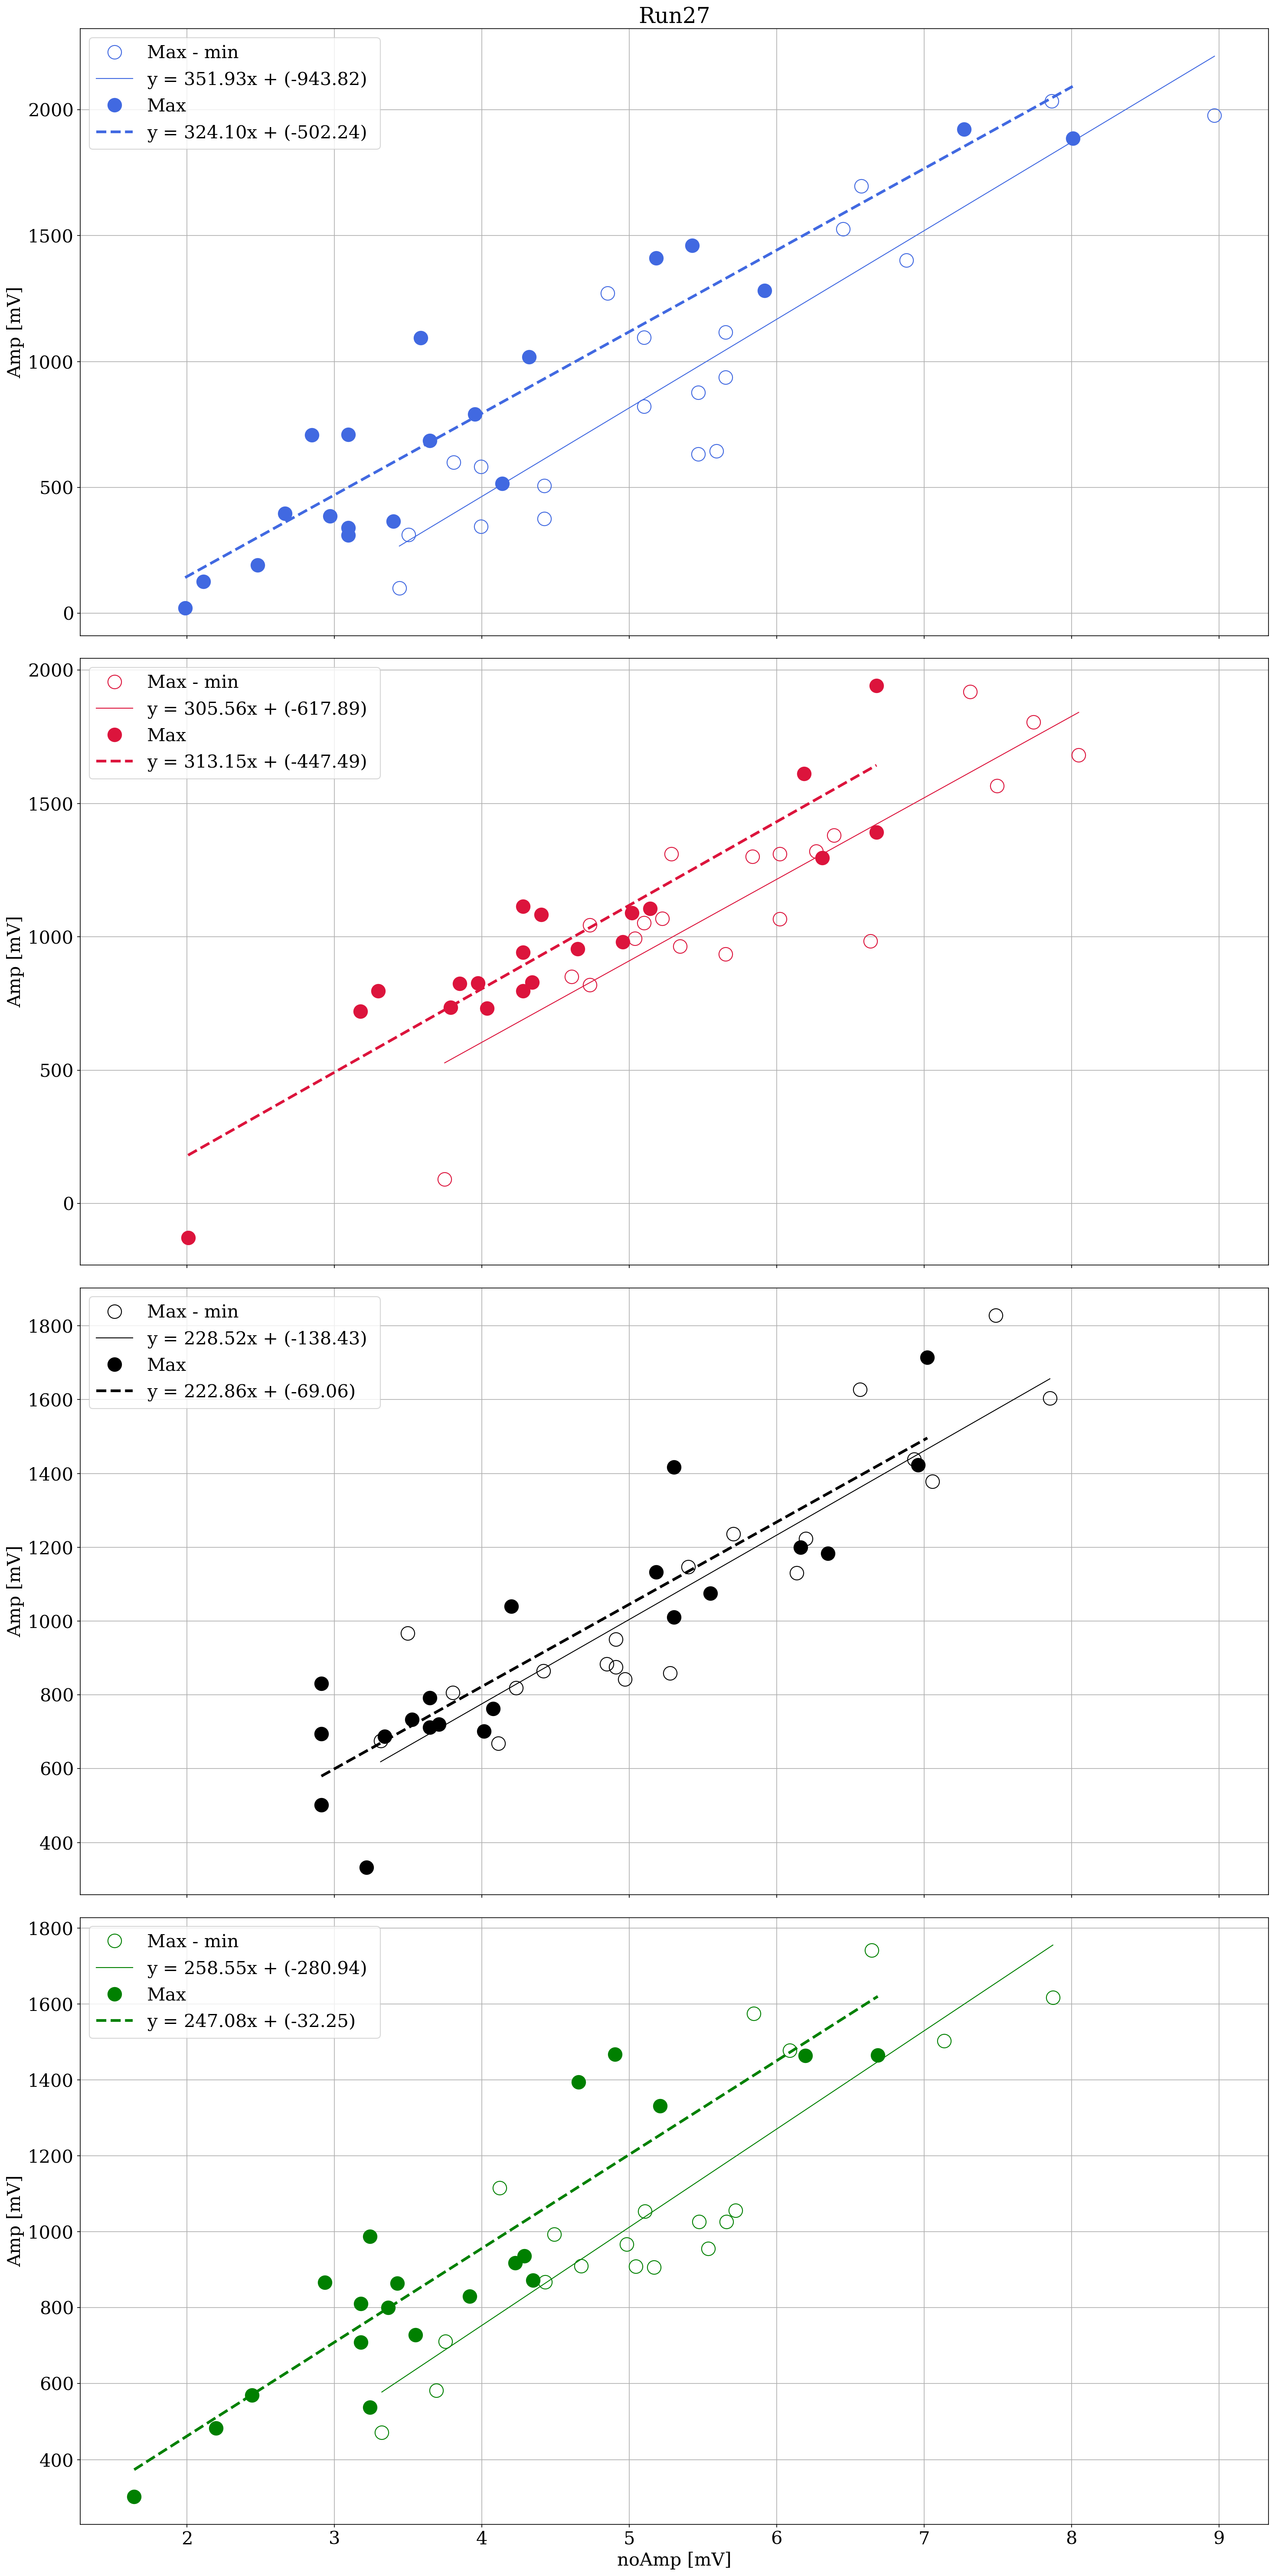

In [47]:
if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(20, len(Amp_channels)*10), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(Amp_channels):

    if len(Amp_channels) > 1:
        ax = axs[i]

    voltage_noAmp   = filtered_df[f'{noAmp_channels[i]}'].values
    voltage_Amp     = filtered_df[f'{Amp_channels[i]}'].values

    t_matrix        = time.reshape(nevents, -1)
    
    v_matrix_noAmp  = voltage_noAmp.reshape(nevents, -1)
    v_matrix_Amp    = voltage_Amp.reshape(nevents, -1)

    # v_matrix_corrected_noAmp, baselines_noAmp, window_noAmp = cig.BaselineCorrection(v_matrix_noAmp, window=window_width)
    # v_matrix_corrected_Amp, baselines_Amp, window_Amp       = cig.BaselineCorrection(v_matrix_Amp, window=window_width)


    v_matrix_corrected_noAmp    = v_matrix_noAmp - fixBaselines_noAmp[f'CH{i+1}']
    v_matrix_corrected_Amp      = v_matrix_Amp - fixBaselines_Amp[f'CH{i+1}']

    v_noAmp = v_matrix_corrected_noAmp[selected_ev]
    v_Amp   = v_matrix_corrected_Amp[selected_ev]
    t = t_matrix[selected_ev]

    time_window = (1.7e-6 < t)  & (3e-6 > t)

    amp_noAmp   = v_matrix_corrected_noAmp[:, time_window].max(axis=1) - v_matrix_corrected_noAmp[:, time_window].min(axis=1)
    amp_Amp     = v_matrix_corrected_Amp[:, time_window].max(axis=1) - v_matrix_corrected_Amp[:, time_window].min(axis=1)
    
    mask = v_matrix_corrected_Amp[:, time_window].max(axis=1) < 2000
    top = 20

    x = amp_noAmp[mask][:top]
    y = amp_Amp[mask][:top]
    ax.plot(x, y, marker='o', linestyle='',
            markerfacecolor='None', color= colors[i], markersize=15, alpha = 1, linewidth=4, 
            label= 'Max - min'
            )
    
    params, cov = np.polyfit(x, y, 1, cov=True)
    m, b        = params

    x_fit = np.linspace(x.min(), x.max(), 200)
    y_fit = m * x_fit + b
    y_fit_var = (x_fit**2) * cov[0,0] + cov[1,1] + 2 * x_fit * cov[0,1]
    y_fit_err = np.sqrt(y_fit_var)

    ax.plot(x_fit, y_fit, colors[i], lw=1, label=f'y = {m:.2f}x + ({b:.2f}) ')


    x = v_matrix_corrected_noAmp[:, time_window].max(axis=1)[mask][:top]
    y = v_matrix_corrected_Amp[:, time_window].max(axis=1)[mask][:top]
    ax.plot(x, y, 
            marker='o', linestyle='',
            color= colors[i], markersize=15, alpha = 1, linewidth=4, 
            label= 'Max'
            )
    params, cov = np.polyfit(x, y, 1, cov=True)
    m, b        = params

    x_fit = np.linspace(x.min(), x.max(), 200)
    y_fit = m * x_fit + b
    y_fit_var = (x_fit**2) * cov[0,0] + cov[1,1] + 2 * x_fit * cov[0,1]
    y_fit_err = np.sqrt(y_fit_var)

    ax.plot(x_fit, y_fit, '--', color = colors[i], lw=3, label=f'y = {m:.2f}x + ({b:.2f}) ')

    # hist, xedges, yedges, img = ax.hist2d(amp_noAmp[mask], amp_Amp[mask], bins=[100, 100], 
    #                                       cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3), label= 'Max - min')
    # hist, xedges, yedges, img = ax.hist2d(v_matrix_corrected_noAmp[:, time_window].max(axis=1)[mask], 
    #                                       v_matrix_corrected_Amp[:, time_window].max(axis=1)[mask], 
    #                                       bins=[100, 100], 
    #                                       cmap='viridis', norm=mcolors.PowerNorm(gamma=0.3), label= 'Max')


    ax.set_ylabel(f'Amp [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('noAmp [mV]')
else:
    ax.set_xlabel('noAmp [mV]')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

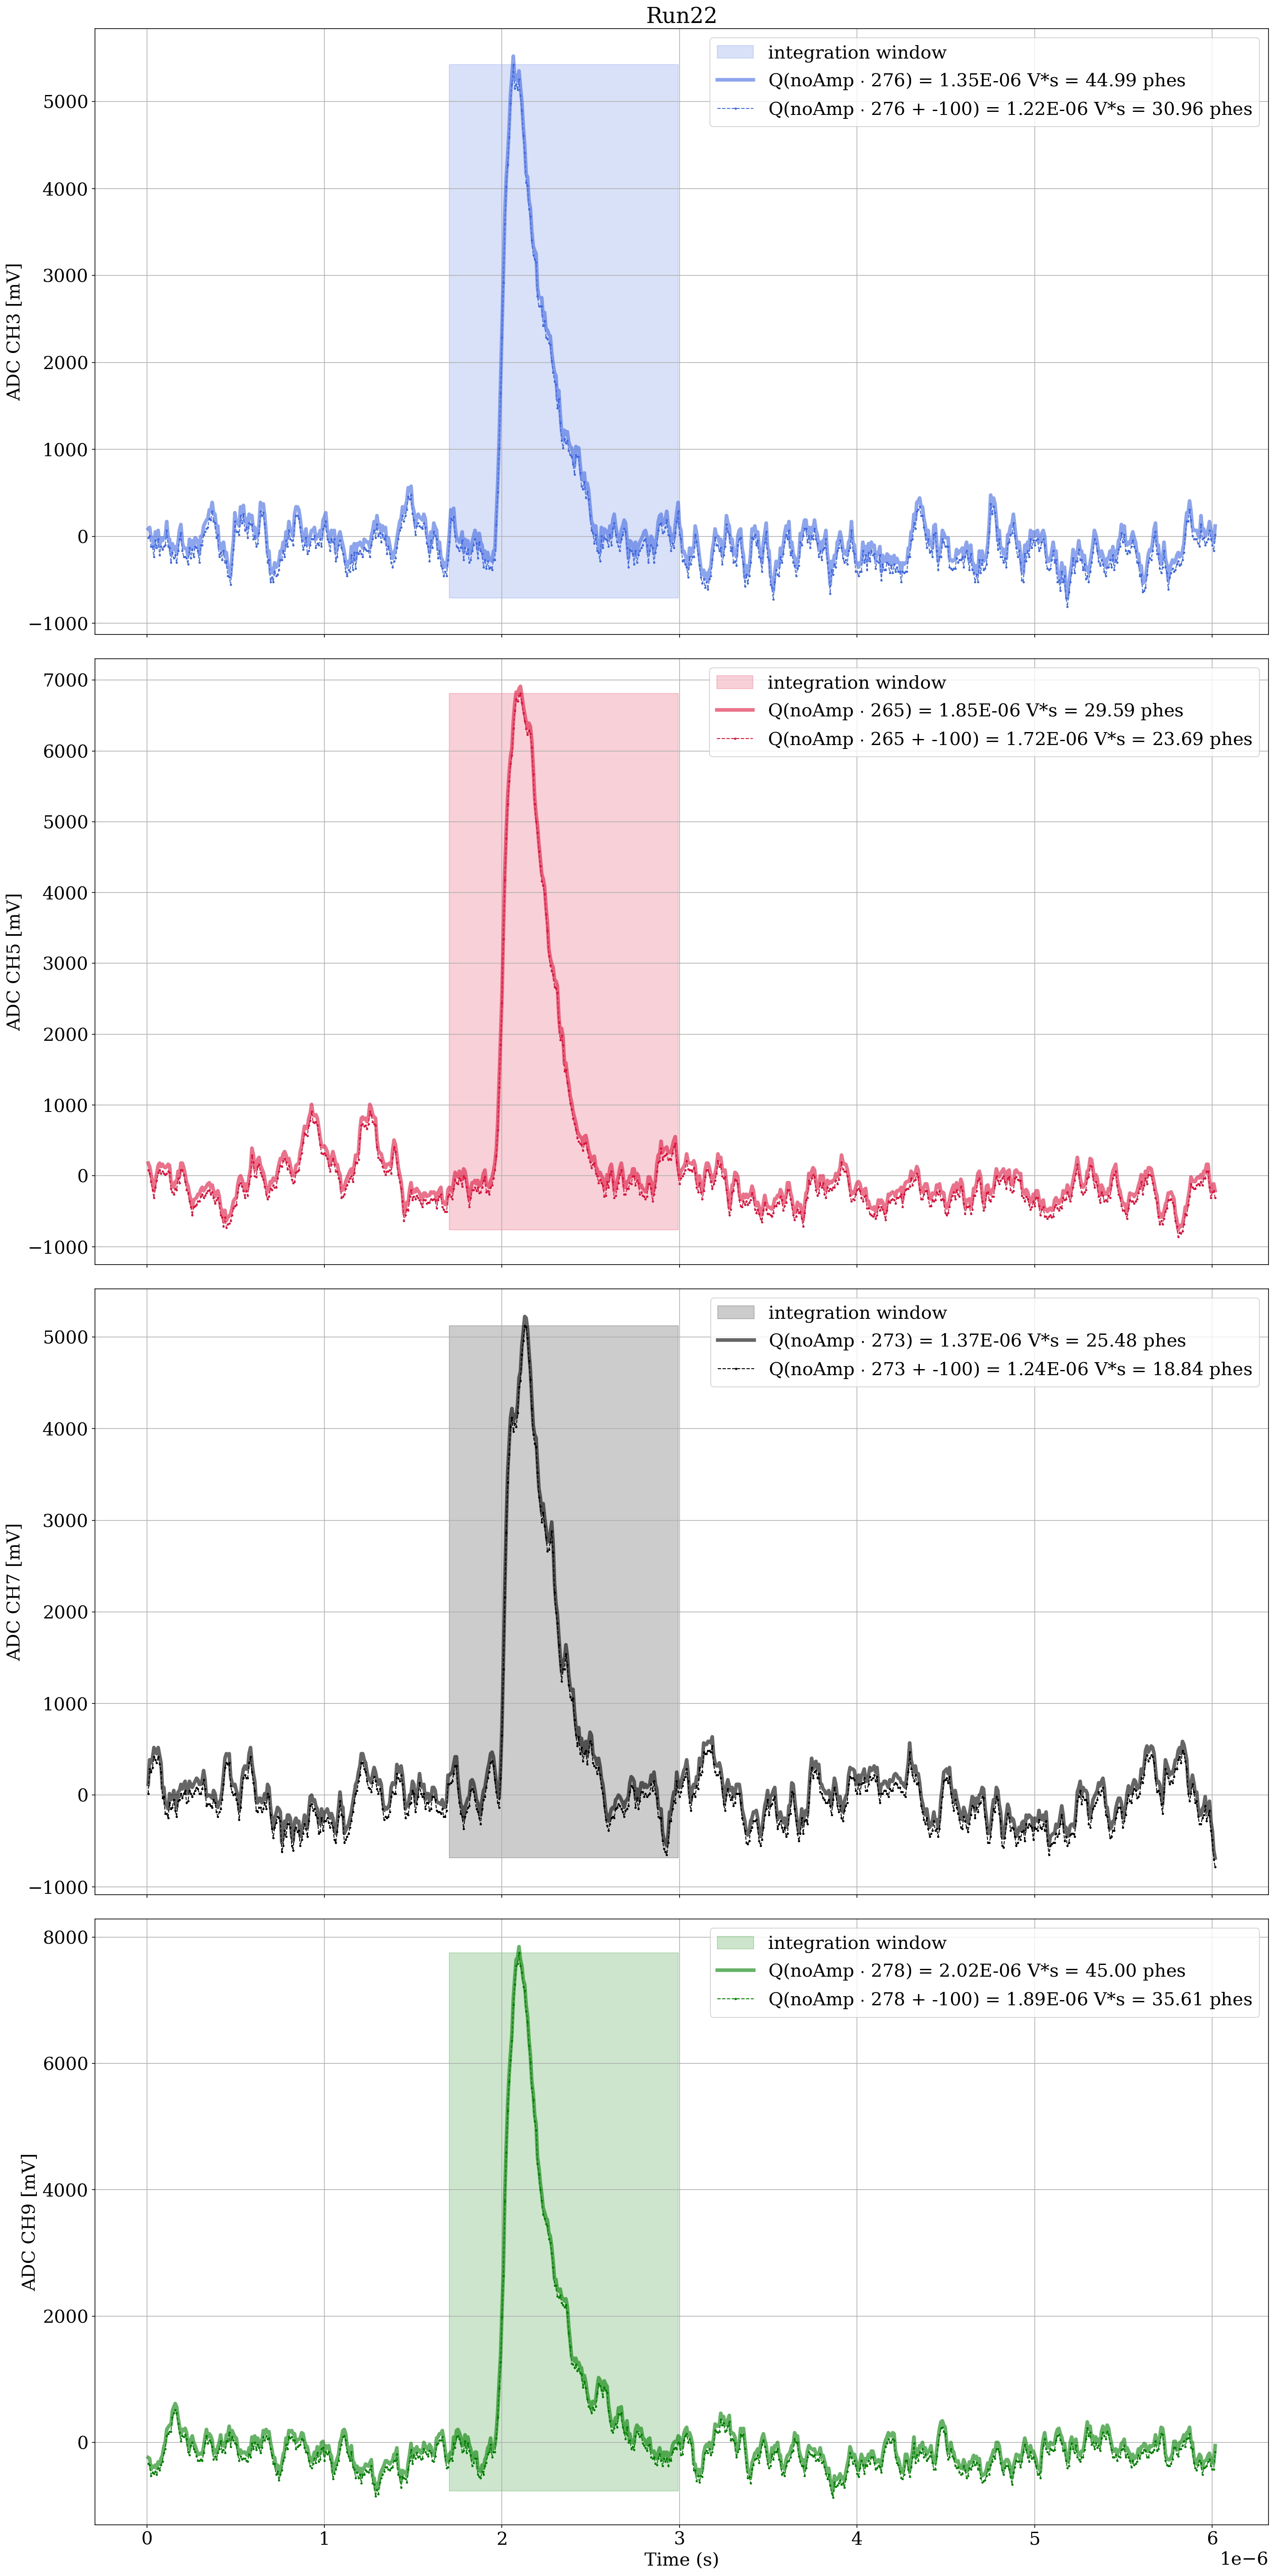

In [ ]:


if len(Amp_channels) > 1:
    fig, axs = plt.subplots(len(Amp_channels), 1, figsize=(20, len(Amp_channels)*10), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=150, sharex=True)

if len(Amp_channels) > 1:
    axs[0].set_title(f'{run}')
else:
    ax.set_title(f'{run}')


time = filtered_df['TIME'].values

# Plot CHs
for i, ch in enumerate(Amp_channels):

    if len(Amp_channels) > 1:
        ax = axs[i]

    voltage_noAmp   = filtered_df[f'{noAmp_channels[i]}'].values

    t_matrix        = time.reshape(nevents, -1)
    
    v_matrix_noAmp  = voltage_noAmp.reshape(nevents, -1)

    v_matrix_corrected_noAmp, baselines_noAmp, window_noAmp = cig.BaselineCorrection(v_matrix_noAmp, window=window_width)

    v_noAmp = v_matrix_corrected_noAmp[selected_ev]
    t = t_matrix[selected_ev]

    time_window = (1.7e-6 < t)  & (3e-6 > t)

    offset = -100 # [mV]
    charge_noAmp = np.trapz(v_noAmp[time_window]*1e-3, 
                            x = t[time_window])
    charge_Amp_offset = np.trapz((amp_factors[f'CH{i+1}'][0]*v_noAmp[time_window] + offset)*1e-3, 
                                   x = t[time_window])
    
    charge_noAmp_phes           = cig.ChargeToPes(charge_noAmp, channel=i+1, temp = temperature, amplified = False, CHAmp=amp_factors)
    charge_Amp_offset_phes    = cig.ChargeToPes(charge_Amp_offset, channel=i+1, temp = temperature, amplified = True, CHAmp=amp_factors)
    
    ax.fill_between(t[time_window], 
                    ((v_noAmp*amp_factors[f'CH{i+1}'][0]).min()), 
                    ((v_noAmp*amp_factors[f'CH{i+1}'][0] + offset).max()), 
                    color = colors[i], alpha = 0.2, label = 'integration window')


    ax.plot(t_matrix[selected_ev], amp_factors[f'CH{i+1}'][0]*v_noAmp, marker='', linestyle='-',
                color= colors[i], markersize=3, alpha = 0.6, linewidth=4, 
                label=fr"Q(noAmp $\cdot$ {amp_factors[f'CH{i+1}'][0]:.0f}) = {(amp_factors[f'CH{i+1}'][0]*charge_noAmp):.2E} V*s = {charge_noAmp_phes:.2f} phes")
    
    ax.plot(t_matrix[selected_ev], amp_factors[f'CH{i+1}'][0]*v_noAmp + offset, marker='.', linestyle='--',
                color= colors[i], markersize=3, linewidth=1, 
                label=fr"Q(noAmp $\cdot$ {amp_factors[f'CH{i+1}'][0]:.0f} + {offset}) = {charge_Amp_offset:.2E} V*s = {charge_Amp_offset_phes:.2f} phes")
    


    ax.set_ylabel(f'ADC {all_channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(all_channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

In [37]:
charge = np.trapz(np.ones_like(t[time_window])*1*1e-3, 
                            x = t[time_window])
for i in range(4):
    print(cig.ChargeToPes(charge, channel=i+1, temp = temperature, amplified = False, CHAmp=amp_factors))

9.585885558248746
4.733958191290625
5.215673707095914
7.385652255565252


In [38]:
cig.ChargeToPes(1.6e-9, channel=4, temp = temperature, amplified = False, CHAmp=amp_factors)

9.225744548853552

In [3]:
amp_factors = {'CH1':(313, 5.21e-8),
               'CH2':(254, 8.18e-8),
               'CH3':(254, 7.41e-8),
               'CH4':(326, 6.86e-8)
               }


In [5]:
cig.ChargeToPes(10e-8, channel=4, temp = '8deg', amplified = True, CHAmp=amp_factors)

1.6869070208728651